# Comprehensive TMT Analysis - All Scenarios

This notebook performs a comprehensive analysis of Total Miscoordination Time (TMT) across all scenarios in the relay coordination system. It includes:

- **Multi-scenario TMT analysis** with before/after optimization comparisons
- **Statistical analysis** across all scenarios
- **Advanced visualizations** including heatmaps, box plots, and trend analysis
- **Quality assessment** and recommendations per scenario
- **Export capabilities** for academic publications

## Features:
- Portable configuration (works from any directory)
- English-only output
- PNG-only plots with inline display
- Comprehensive reporting in multiple formats
- Per-scenario and cross-scenario analysis


In [51]:
# %% Imports and Configuration
import json
import re
from pathlib import Path
from datetime import datetime
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Set style
plt.style.use('default')
sns.set_palette("husl")

class ProjectConfig:
    def __init__(self):
        # Robust project root detection
        current_dir = Path.cwd()
        if current_dir.name == 'notebooks' and current_dir.parent.name == 'analysis':
            self.PROJECT_ROOT = current_dir.parent.parent
        elif current_dir.name == 'analysis':
            self.PROJECT_ROOT = current_dir.parent
        else:
            self.PROJECT_ROOT = current_dir if (current_dir / 'data').exists() else current_dir.parent
        
        # Data files - BEFORE and AFTER optimization
        self.data_file_name = "automation_results.json"
        self.data_file_path = self.PROJECT_ROOT / "data" / "raw" / self.data_file_name
        
        # Check for optimized data files
        self.optimized_files = {}
        processed_dir = self.PROJECT_ROOT / "data" / "processed"
        
        # Look for scenario-specific optimized files
        for scenario_file in processed_dir.glob("*_optimized.json"):
            scenario_name = scenario_file.stem.replace("_optimized", "")
            self.optimized_files[scenario_name] = scenario_file
        
        # Also check for any scenario files that might exist
        for scenario_file in processed_dir.glob("automation_results_scenario_*.json"):
            if not scenario_file.name.endswith("_optimized.json"):
                scenario_name = scenario_file.stem.replace("automation_results_", "")
                if scenario_name not in self.optimized_files:
                    self.optimized_files[scenario_name] = None  # No optimized version available
        
        # Output directories
        self.OUTPUT_DIR = self.PROJECT_ROOT / "results" / "plots" / "tmt_analysis"
        self.TABLES_DIR = self.PROJECT_ROOT / "results" / "tables"
        self.REPORTS_DIR = self.PROJECT_ROOT / "results" / "reports"
        self.FIGURES_DIR = self.PROJECT_ROOT / "results" / "figures"
        
        # Create directories
        for dir_path in [self.OUTPUT_DIR, self.TABLES_DIR, self.REPORTS_DIR, self.FIGURES_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)
        
        # Analysis parameters
        self.CTI = 0.2  # Coordination Time Interval
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        print(f"Project root: {self.PROJECT_ROOT}")
        print(f"Data file (BEFORE): {self.data_file_path}")
        print(f"Optimized files (AFTER): {list(self.optimized_files.keys())}")
        print(f"Output directory: {self.OUTPUT_DIR}")

# Initialize configuration
config = ProjectConfig()


Project root: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
Data file (BEFORE): /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/raw/automation_results.json
Optimized files (AFTER): ['automation_results_scenario_18', 'automation_results_scenario_10', 'automation_results_scenario_3', 'automation_results_scenario_61', 'automation_results_scenario_17', 'automation_results_scenario_66', 'automation_results_scenario_4', 'automation_results_scenario_16', 'automation_results_scenario_5', 'automation_results_scenario_67', 'automation_results_scenario_11', 'automation_results_scenario_60', 'automation_results_scenario_2', 'automation_results_scenario_68', 'automation_results_scenario_19', 'automation_results_scenario_62', 'automation_results_scenario_13', 'automation_results_scenario_8', 'automation_results_scenario_65', 'automation_results_scenario_7', 'automation_results_scenario_14', 'automation_results_scenario_6', 'automation_results_scenario_64', 'automation_results_

In [52]:
# %% Data Loading and Validation
def validate_file_path(file_path):
    """Validate that the data file exists and is readable."""
    if not file_path.exists():
        raise FileNotFoundError(f"Data file not found: {file_path}")
    return True

def load_relay_data(file_path):
    """Load relay coordination data from JSON file."""
    validate_file_path(file_path)
    
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    if not isinstance(data, list):
        raise ValueError("Data must be a list of relay pairs")
    
    print(f"✅ Loaded {len(data)} relay pairs from {file_path.name}")
    return data

def extract_scenarios(data):
    """Extract unique scenarios from the data."""
    scenarios = set()
    for pair in data:
        scenario_id = pair.get('scenario_id')
        if scenario_id:
            scenarios.add(scenario_id)
    
    scenarios = sorted(list(scenarios))
    print(f"📊 Found scenarios: {scenarios}")
    return scenarios

def load_before_after_data():
    """Load both BEFORE and AFTER optimization data for comparison."""
    # Load BEFORE data (original automation results)
    before_data = load_relay_data(config.data_file_path)
    before_scenarios = extract_scenarios(before_data)
    
    # Load AFTER data (optimized results)
    after_data = {}
    available_after_scenarios = []
    scenarios_without_optimization = []
    
    print(f"📊 Found {len(before_scenarios)} scenarios in original data:")
    for scenario in before_scenarios:
        print(f"  - {scenario}")
    
    for scenario_name, file_path in config.optimized_files.items():
        if file_path is not None:
            try:
                after_data[scenario_name] = load_relay_data(file_path)
                available_after_scenarios.append(scenario_name)
                print(f"✅ Loaded optimized data for {scenario_name}")
            except Exception as e:
                print(f"⚠️  Could not load optimized data for {scenario_name}: {e}")
                scenarios_without_optimization.append(scenario_name)
        else:
            scenarios_without_optimization.append(scenario_name)
            print(f"ℹ️  No optimized data available for {scenario_name}")
    
    print(f"\n📊 Summary:")
    print(f"  Scenarios with optimization: {len(available_after_scenarios)}")
    print(f"  Scenarios without optimization: {len(scenarios_without_optimization)}")
    print(f"  Total scenarios: {len(before_scenarios)}")
    
    return before_data, before_scenarios, after_data, available_after_scenarios, scenarios_without_optimization

# Load both BEFORE and AFTER data
before_data, before_scenarios, after_data, available_after_scenarios, scenarios_without_optimization = load_before_after_data()


✅ Loaded 6800 relay pairs from automation_results.json
📊 Found scenarios: ['scenario_1', 'scenario_10', 'scenario_11', 'scenario_12', 'scenario_13', 'scenario_14', 'scenario_15', 'scenario_16', 'scenario_17', 'scenario_18', 'scenario_19', 'scenario_2', 'scenario_20', 'scenario_21', 'scenario_22', 'scenario_23', 'scenario_24', 'scenario_25', 'scenario_26', 'scenario_27', 'scenario_28', 'scenario_29', 'scenario_3', 'scenario_30', 'scenario_31', 'scenario_32', 'scenario_33', 'scenario_34', 'scenario_35', 'scenario_36', 'scenario_37', 'scenario_38', 'scenario_39', 'scenario_4', 'scenario_40', 'scenario_41', 'scenario_42', 'scenario_43', 'scenario_44', 'scenario_45', 'scenario_46', 'scenario_47', 'scenario_48', 'scenario_49', 'scenario_5', 'scenario_50', 'scenario_51', 'scenario_52', 'scenario_53', 'scenario_54', 'scenario_55', 'scenario_56', 'scenario_57', 'scenario_58', 'scenario_59', 'scenario_6', 'scenario_60', 'scenario_61', 'scenario_62', 'scenario_63', 'scenario_64', 'scenario_65', '

In [53]:
# %% TMT Analysis Functions
def calculate_tmt_metrics(pairs, cti=0.2):
    """Calculate TMT and coordination metrics for a set of relay pairs."""
    if not pairs:
        return {
            'total_pairs': 0,
            'coordinated_pairs': 0,
            'uncoordinated_pairs': 0,
            'coordination_percentage': 0.0,
            'tmt_signed': 0.0,
            'tmt_magnitude': 0.0,
            'mean_dt': 0.0,
            'std_dt': 0.0,
            'min_dt': 0.0,
            'max_dt': 0.0,
            'median_dt': 0.0
        }
    
    dt_values = []
    coordinated = 0
    tmt_signed = 0.0
    
    for pair in pairs:
        main_relay = pair.get('main_relay', {})
        backup_relay = pair.get('backup_relay', {})
        
        time_main = main_relay.get('Time_out')
        time_backup = backup_relay.get('Time_out')
        
        if time_main is not None and time_backup is not None:
            dt = (time_backup - time_main) - cti
            dt_values.append(dt)
            
            if dt >= 0:
                coordinated += 1
            else:
                tmt_signed += dt  # dt is negative for miscoordination
    
    total_pairs = len(dt_values)
    uncoordinated = total_pairs - coordinated
    coordination_percentage = (coordinated / total_pairs * 100) if total_pairs > 0 else 0.0
    tmt_magnitude = abs(tmt_signed)
    
    # Statistics
    dt_array = np.array(dt_values)
    mean_dt = np.mean(dt_array) if len(dt_array) > 0 else 0.0
    std_dt = np.std(dt_array) if len(dt_array) > 0 else 0.0
    min_dt = np.min(dt_array) if len(dt_array) > 0 else 0.0
    max_dt = np.max(dt_array) if len(dt_array) > 0 else 0.0
    median_dt = np.median(dt_array) if len(dt_array) > 0 else 0.0
    
    return {
        'total_pairs': total_pairs,
        'coordinated_pairs': coordinated,
        'uncoordinated_pairs': uncoordinated,
        'coordination_percentage': coordination_percentage,
        'tmt_signed': tmt_signed,
        'tmt_magnitude': tmt_magnitude,
        'mean_dt': mean_dt,
        'std_dt': std_dt,
        'min_dt': min_dt,
        'max_dt': max_dt,
        'median_dt': median_dt,
        'dt_values': dt_values
    }

def analyze_all_scenarios_comprehensive(before_data, after_data, available_scenarios, scenarios_without_optimization, cti=0.2):
    """Analyze ALL scenarios - both with and without optimization data."""
    all_scenario_results = {}
    
    print(f"\n🔍 Analyzing ALL {len(before_scenarios)} scenarios...")
    
    # Analyze scenarios WITH optimization data
    for scenario in available_scenarios:
        print(f"\n📊 Analyzing scenario WITH optimization: {scenario}")
        
        # Get BEFORE data
        before_pairs = [pair for pair in before_data if pair.get('scenario_id') == scenario]
        before_metrics = calculate_tmt_metrics(before_pairs, cti)
        
        # Get AFTER data
        after_pairs = after_data.get(scenario, [])
        after_metrics = calculate_tmt_metrics(after_pairs, cti)
        
        # Calculate improvements
        tmt_improvement = after_metrics['tmt_signed'] - before_metrics['tmt_signed']
        coord_improvement = after_metrics['coordination_percentage'] - before_metrics['coordination_percentage']
        
        all_scenario_results[scenario] = {
            'has_optimization': True,
            'before': before_metrics,
            'after': after_metrics,
            'improvements': {
                'tmt_improvement': tmt_improvement,
                'coord_improvement': coord_improvement,
                'tmt_improvement_pct': (tmt_improvement / abs(before_metrics['tmt_signed']) * 100) if before_metrics['tmt_signed'] != 0 else 0,
                'coord_improvement_pct': coord_improvement
            }
        }
        
        print(f"  BEFORE: TMT={before_metrics['tmt_signed']:.3f}s, Coord={before_metrics['coordination_percentage']:.1f}%")
        print(f"  AFTER:  TMT={after_metrics['tmt_signed']:.3f}s, Coord={after_metrics['coordination_percentage']:.1f}%")
        print(f"  IMPROVEMENT: TMT={tmt_improvement:+.3f}s, Coord={coord_improvement:+.1f}%")
    
    # Analyze scenarios WITHOUT optimization data
    for scenario in scenarios_without_optimization:
        print(f"\n📊 Analyzing scenario WITHOUT optimization: {scenario}")
        
        # Get BEFORE data only
        before_pairs = [pair for pair in before_data if pair.get('scenario_id') == scenario]
        before_metrics = calculate_tmt_metrics(before_pairs, cti)
        
        all_scenario_results[scenario] = {
            'has_optimization': False,
            'before': before_metrics,
            'after': None,
            'improvements': None
        }
        
        print(f"  BEFORE: TMT={before_metrics['tmt_signed']:.3f}s, Coord={before_metrics['coordination_percentage']:.1f}%")
        print(f"  STATUS: No optimization data available")
    
    return all_scenario_results

# Analyze ALL scenarios comprehensively
all_scenario_results = analyze_all_scenarios_comprehensive(before_data, after_data, available_after_scenarios, scenarios_without_optimization, config.CTI)



🔍 Analyzing ALL 68 scenarios...

📊 Analyzing scenario WITH optimization: automation_results_scenario_18
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=-4.717s, Coord=98.0%
  IMPROVEMENT: TMT=-4.717s, Coord=+98.0%

📊 Analyzing scenario WITH optimization: automation_results_scenario_10
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=-4.735s, Coord=97.0%
  IMPROVEMENT: TMT=-4.735s, Coord=+97.0%

📊 Analyzing scenario WITH optimization: automation_results_scenario_3
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=-5.875s, Coord=98.0%
  IMPROVEMENT: TMT=-5.875s, Coord=+98.0%

📊 Analyzing scenario WITH optimization: automation_results_scenario_61
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=0.000s, Coord=100.0%
  IMPROVEMENT: TMT=+0.000s, Coord=+100.0%

📊 Analyzing scenario WITH optimization: automation_results_scenario_17
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=-2.892s, Coord=94.0%
  IMPROVEMENT: TMT=-2.892s, Coord=+94.0%

📊 Analyzing scenario WITH optimization: automation_results_sc

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [54]:
# %% Create Comprehensive DataFrames for BEFORE/AFTER Comparison
def create_comparison_summary_df(comparison_results):
    """Create a summary DataFrame comparing BEFORE and AFTER optimization."""
    data = []
    for scenario, results in comparison_results.items():
        before = results['before']
        after = results['after']
        improvements = results['improvements']
        
        data.append({
            'Scenario': scenario,
            'Total_Pairs': before['total_pairs'],
            'TMT_Before': before['tmt_signed'],
            'TMT_After': after['tmt_signed'],
            'TMT_Improvement': improvements['tmt_improvement'],
            'TMT_Improvement_Pct': improvements['tmt_improvement_pct'],
            'Coord_Before': before['coordination_percentage'],
            'Coord_After': after['coordination_percentage'],
            'Coord_Improvement': improvements['coord_improvement'],
            'Coord_Improvement_Pct': improvements['coord_improvement_pct'],
            'Mean_DT_Before': before['mean_dt'],
            'Mean_DT_After': after['mean_dt'],
            'Std_DT_Before': before['std_dt'],
            'Std_DT_After': after['std_dt']
        })
    
    return pd.DataFrame(data)

def create_detailed_pairs_comparison_df(comparison_results):
    """Create detailed comparison DataFrame for individual pairs."""
    data = []
    
    for scenario, results in comparison_results.items():
        before_pairs = []
        after_pairs = []
        
        # Get BEFORE pairs
        for pair in before_data:
            if pair.get('scenario_id') == scenario:
                main_relay = pair.get('main_relay', {})
                backup_relay = pair.get('backup_relay', {})
                time_main = main_relay.get('Time_out')
                time_backup = backup_relay.get('Time_out')
                
                if time_main is not None and time_backup is not None:
                    dt = (time_backup - time_main) - config.CTI
                    before_pairs.append({
                        'Main_Relay': main_relay.get('relay', 'Unknown'),
                        'Backup_Relay': backup_relay.get('relay', 'Unknown'),
                        'DT': dt,
                        'Coordinated': dt >= 0
                    })
        
        # Get AFTER pairs
        for pair in after_data.get(scenario, []):
            main_relay = pair.get('main_relay', {})
            backup_relay = pair.get('backup_relay', {})
            time_main = main_relay.get('Time_out')
            time_backup = backup_relay.get('Time_out')
            
            if time_main is not None and time_backup is not None:
                dt = (time_backup - time_main) - config.CTI
                after_pairs.append({
                    'Main_Relay': main_relay.get('relay', 'Unknown'),
                    'Backup_Relay': backup_relay.get('relay', 'Unknown'),
                    'DT': dt,
                    'Coordinated': dt >= 0
                })
        
        # Match pairs and create comparison
        for before_pair in before_pairs:
            pair_key = f"{before_pair['Main_Relay']}-{before_pair['Backup_Relay']}"
            
            # Find matching after pair
            after_pair = None
            for ap in after_pairs:
                if f"{ap['Main_Relay']}-{ap['Backup_Relay']}" == pair_key:
                    after_pair = ap
                    break
            
            if after_pair:
                dt_improvement = after_pair['DT'] - before_pair['DT']
                data.append({
                    'Scenario': scenario,
                    'Main_Relay': before_pair['Main_Relay'],
                    'Backup_Relay': before_pair['Backup_Relay'],
                    'DT_Before': before_pair['DT'],
                    'DT_After': after_pair['DT'],
                    'DT_Improvement': dt_improvement,
                    'Coordinated_Before': before_pair['Coordinated'],
                    'Coordinated_After': after_pair['Coordinated'],
                    'Status_Change': 'Improved' if dt_improvement > 0 else 'Worsened' if dt_improvement < 0 else 'No Change'
                })
    
    return pd.DataFrame(data)

# Create DataFrames
comparison_summary_df = create_comparison_summary_df(comparison_results)
pairs_comparison_df = create_detailed_pairs_comparison_df(comparison_results)

print("📊 DataFrames Created:")
print(f"  Comparison Summary: {comparison_summary_df.shape}")
print(f"  Pairs Comparison: {pairs_comparison_df.shape}")

# Display summary
print("\n📋 BEFORE vs AFTER Comparison Summary:")
display(comparison_summary_df.round(3))


📊 DataFrames Created:
  Comparison Summary: (1, 14)
  Pairs Comparison: (0, 0)

📋 BEFORE vs AFTER Comparison Summary:


,Scenario,Total_Pairs,TMT_Before,TMT_After,TMT_Improvement,TMT_Improvement_Pct,Coord_Before,Coord_After,Coord_Improvement,Coord_Improvement_Pct,Mean_DT_Before,Mean_DT_After,Std_DT_Before,Std_DT_After
0,automation_results_scenario_1,0,0.0,0.0,0.0,0,0.0,100.0,100.0,100.0,0.0,0.858,0.0,1.027


🎨 Creating comprehensive BEFORE/AFTER visualizations...
✅ All visualizations saved to results/figures/


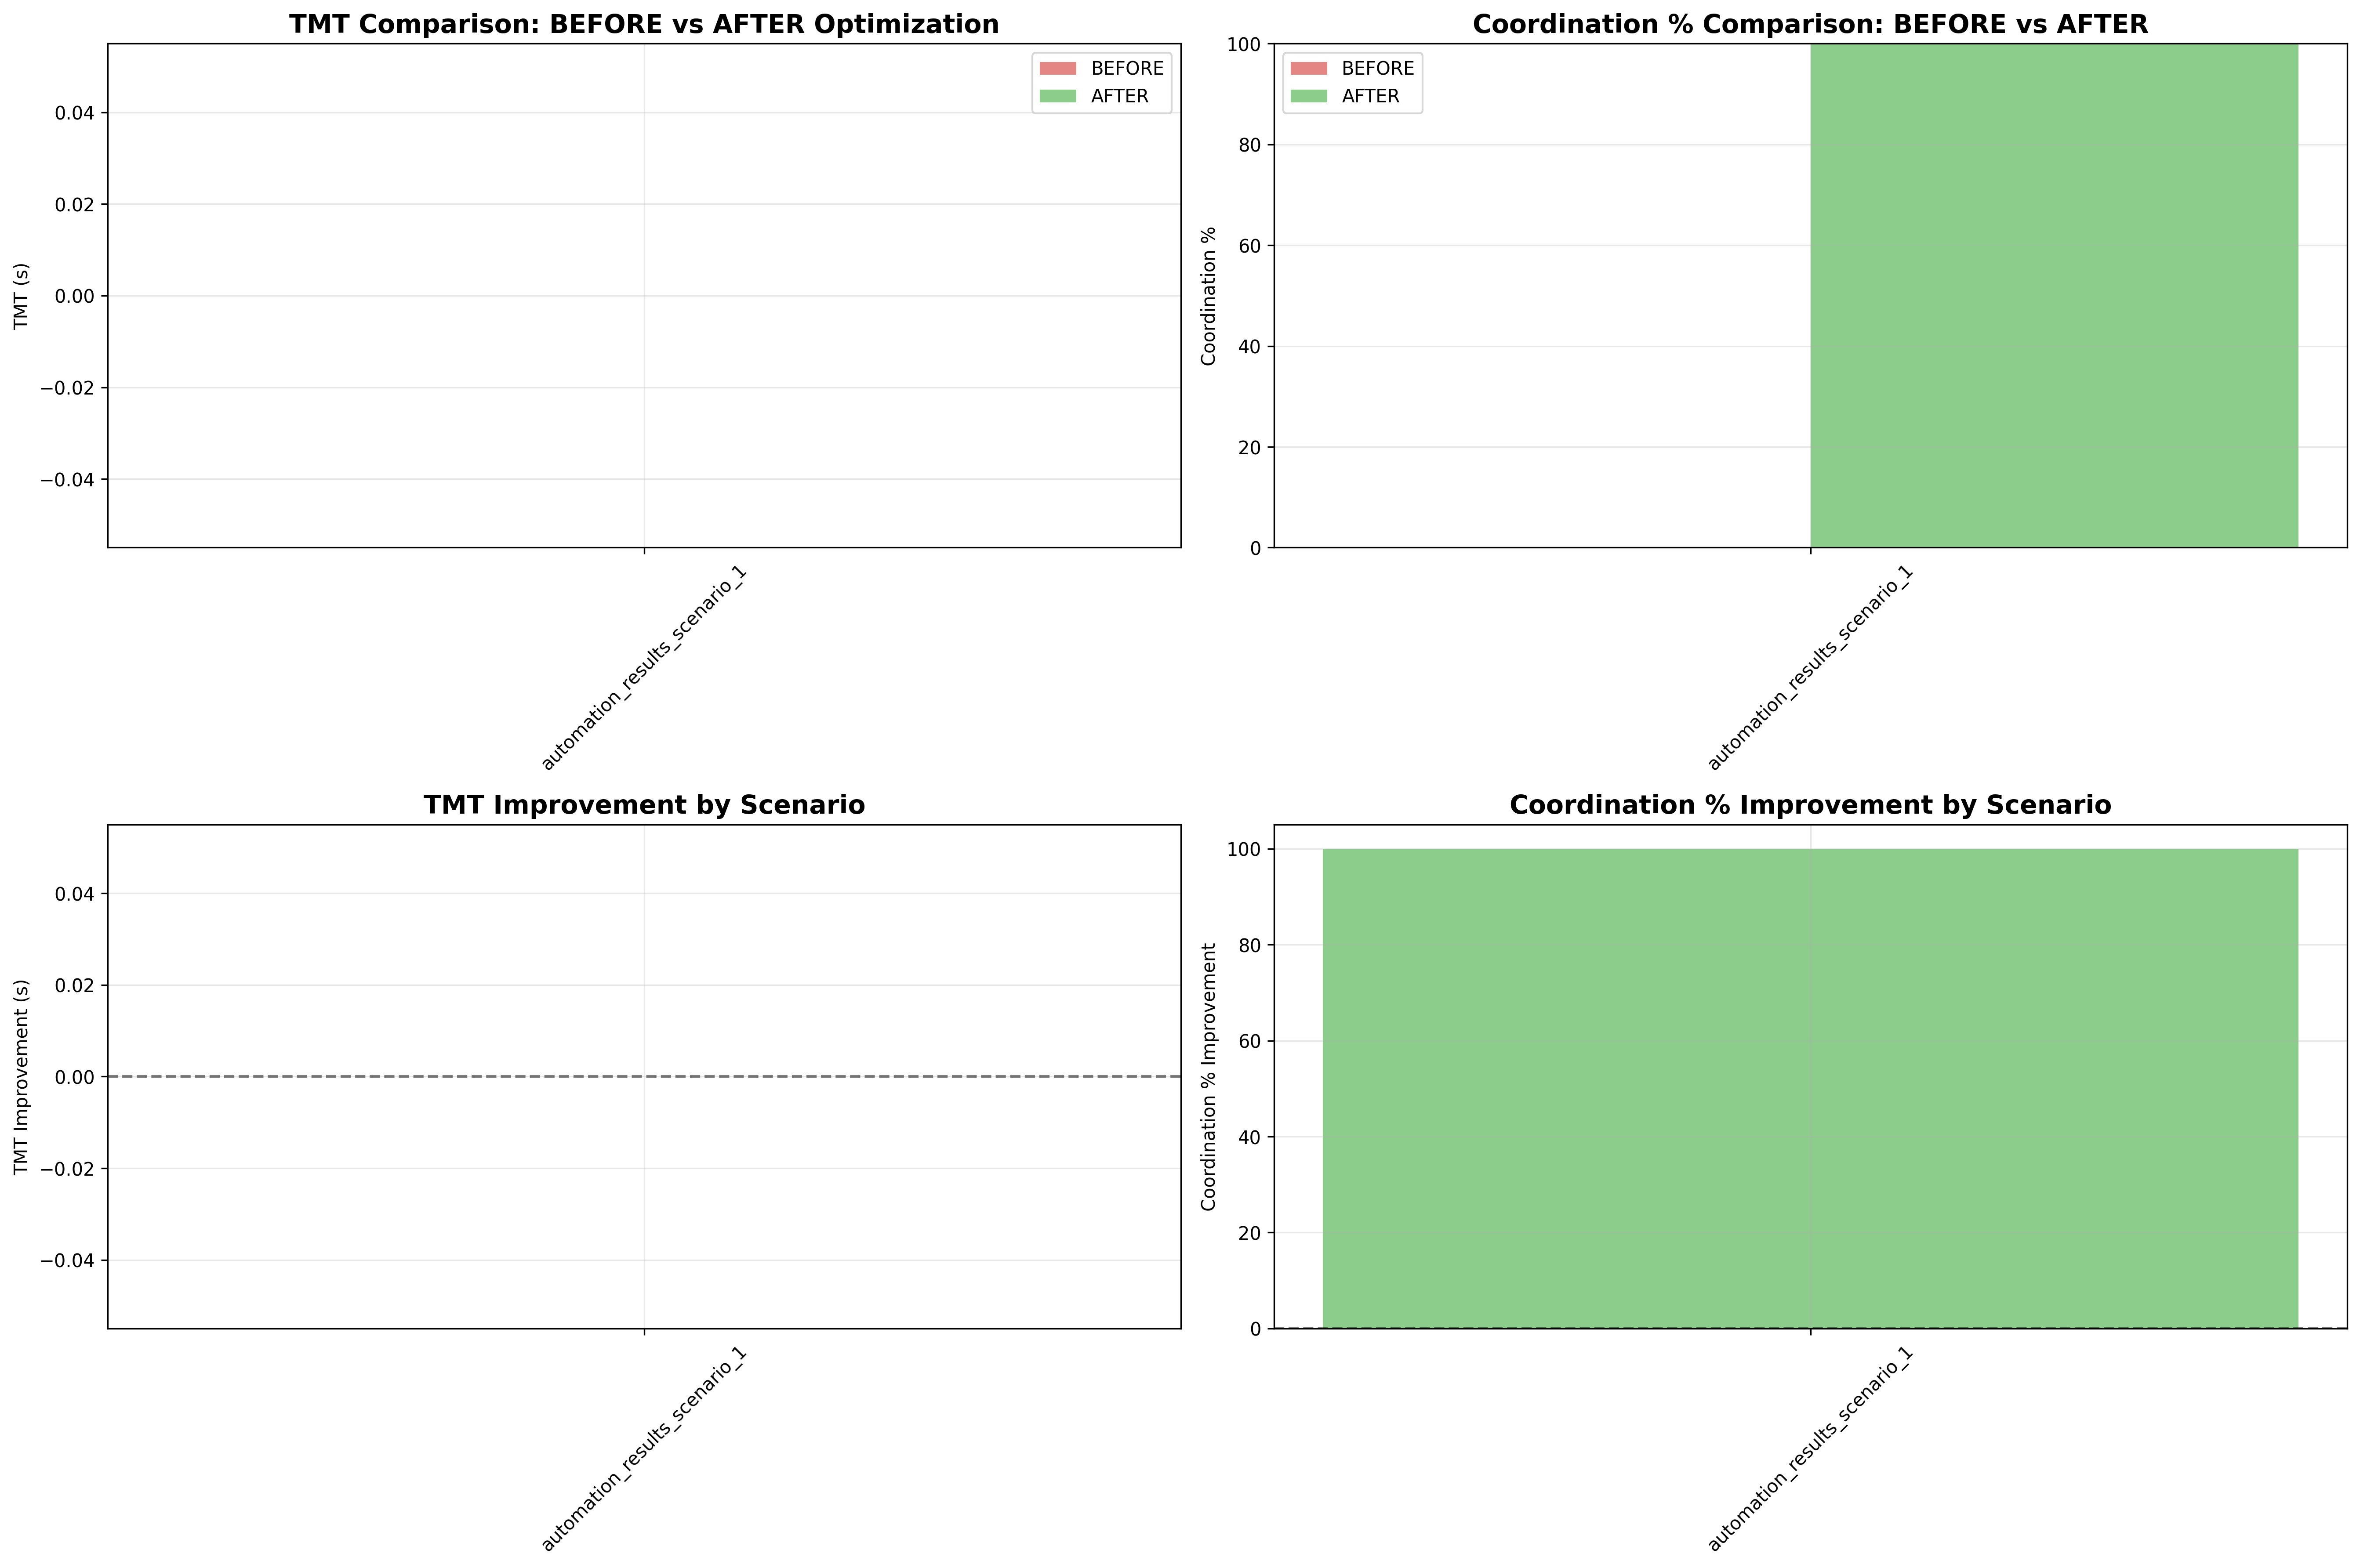

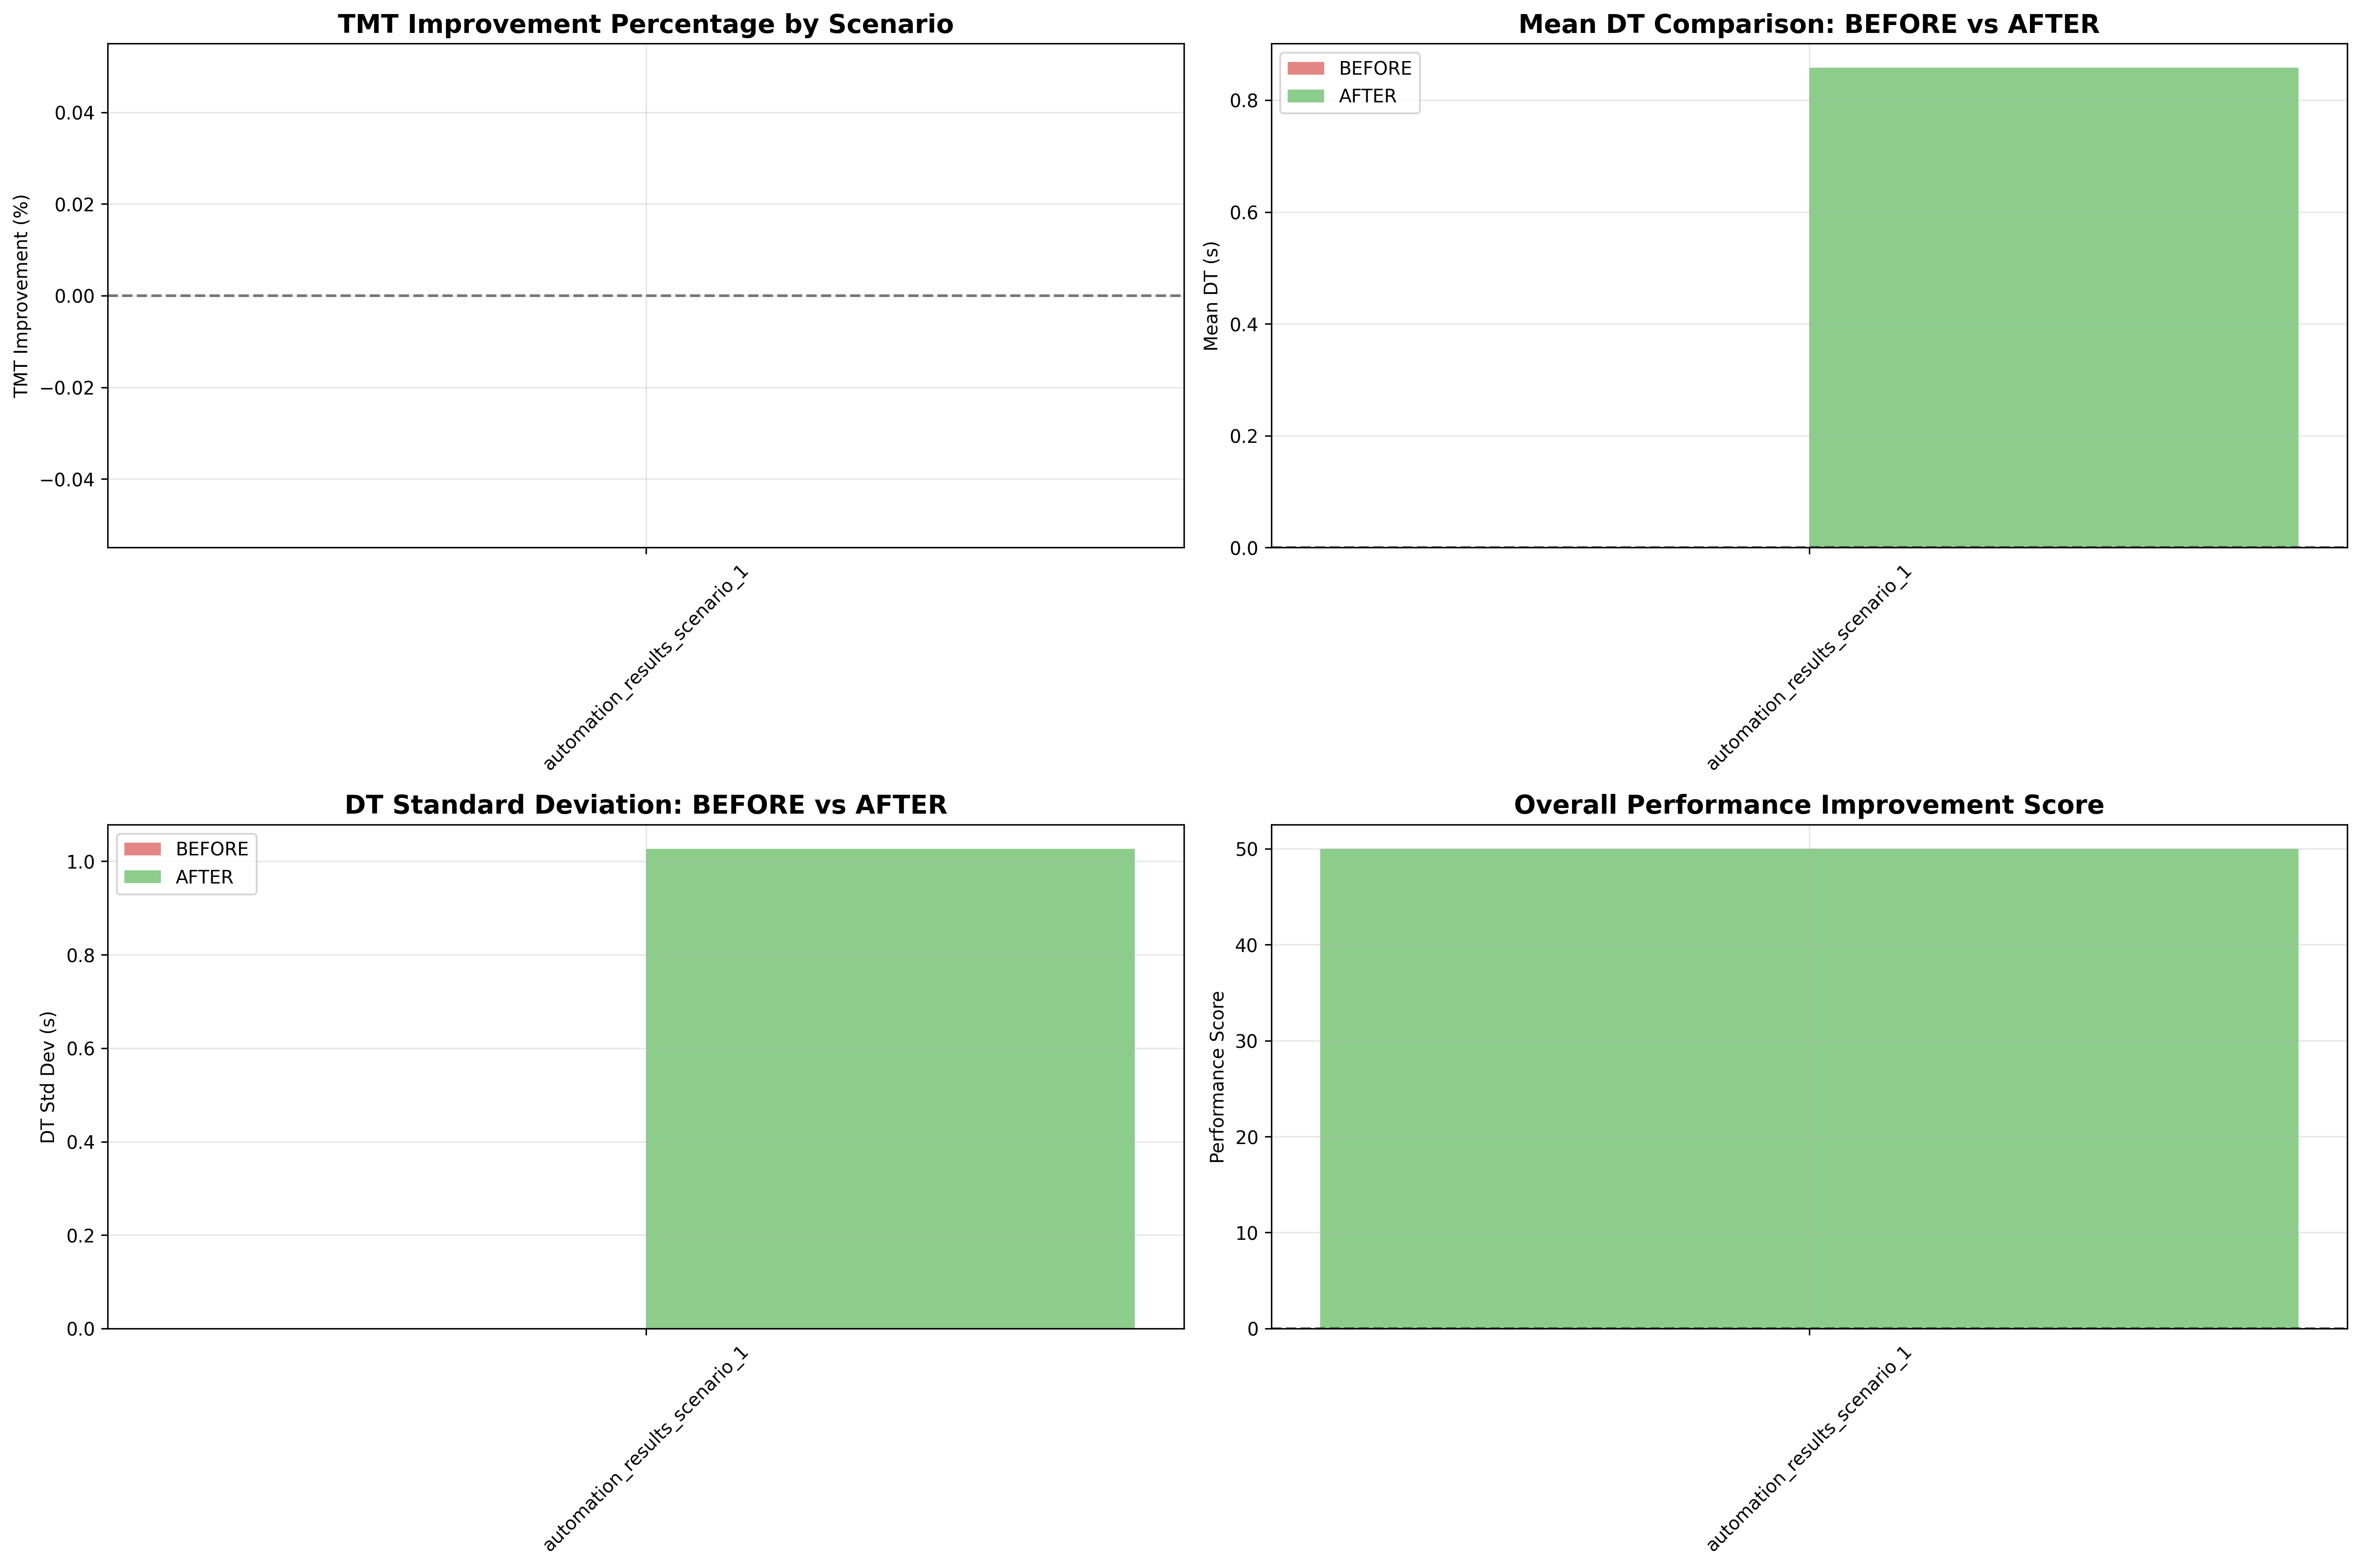

In [55]:
# %% Advanced Visualizations for BEFORE/AFTER Comparison
def create_before_after_comparison_chart(comparison_summary_df):
    """Create comprehensive BEFORE vs AFTER comparison charts."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    scenarios = comparison_summary_df['Scenario']
    x = np.arange(len(scenarios))
    width = 0.35
    
    # 1. TMT Comparison (BEFORE vs AFTER)
    ax1.bar(x - width/2, comparison_summary_df['TMT_Before'], width, 
            label='BEFORE', color='#d9534f', alpha=0.7)
    ax1.bar(x + width/2, comparison_summary_df['TMT_After'], width, 
            label='AFTER', color='#5cb85c', alpha=0.7)
    ax1.set_title('TMT Comparison: BEFORE vs AFTER Optimization', fontsize=14, fontweight='bold')
    ax1.set_ylabel('TMT (s)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenarios, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Coordination Percentage Comparison
    ax2.bar(x - width/2, comparison_summary_df['Coord_Before'], width, 
            label='BEFORE', color='#d9534f', alpha=0.7)
    ax2.bar(x + width/2, comparison_summary_df['Coord_After'], width, 
            label='AFTER', color='#5cb85c', alpha=0.7)
    ax2.set_title('Coordination % Comparison: BEFORE vs AFTER', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Coordination %')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenarios, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # 3. TMT Improvement
    colors = ['#5cb85c' if x > 0 else '#d9534f' for x in comparison_summary_df['TMT_Improvement']]
    ax3.bar(scenarios, comparison_summary_df['TMT_Improvement'], color=colors, alpha=0.7)
    ax3.set_title('TMT Improvement by Scenario', fontsize=14, fontweight='bold')
    ax3.set_ylabel('TMT Improvement (s)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # 4. Coordination Improvement
    colors = ['#5cb85c' if x > 0 else '#d9534f' for x in comparison_summary_df['Coord_Improvement']]
    ax4.bar(scenarios, comparison_summary_df['Coord_Improvement'], color=colors, alpha=0.7)
    ax4.set_title('Coordination % Improvement by Scenario', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Coordination % Improvement')
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_improvement_analysis_chart(comparison_summary_df):
    """Create detailed improvement analysis charts."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    scenarios = comparison_summary_df['Scenario']
    
    # 1. TMT Improvement Percentage
    colors = ['#5cb85c' if x > 0 else '#d9534f' for x in comparison_summary_df['TMT_Improvement_Pct']]
    ax1.bar(scenarios, comparison_summary_df['TMT_Improvement_Pct'], color=colors, alpha=0.7)
    ax1.set_title('TMT Improvement Percentage by Scenario', fontsize=14, fontweight='bold')
    ax1.set_ylabel('TMT Improvement (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # 2. Mean DT Comparison
    x = np.arange(len(scenarios))
    width = 0.35
    ax2.bar(x - width/2, comparison_summary_df['Mean_DT_Before'], width, 
            label='BEFORE', color='#d9534f', alpha=0.7)
    ax2.bar(x + width/2, comparison_summary_df['Mean_DT_After'], width, 
            label='AFTER', color='#5cb85c', alpha=0.7)
    ax2.set_title('Mean DT Comparison: BEFORE vs AFTER', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean DT (s)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenarios, rotation=45)
    ax2.legend()
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Standard Deviation Comparison
    ax3.bar(x - width/2, comparison_summary_df['Std_DT_Before'], width, 
            label='BEFORE', color='#d9534f', alpha=0.7)
    ax3.bar(x + width/2, comparison_summary_df['Std_DT_After'], width, 
            label='AFTER', color='#5cb85c', alpha=0.7)
    ax3.set_title('DT Standard Deviation: BEFORE vs AFTER', fontsize=14, fontweight='bold')
    ax3.set_ylabel('DT Std Dev (s)')
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenarios, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Overall Performance Score
    # Calculate a composite score: (TMT improvement + Coord improvement) / 2
    performance_score = (comparison_summary_df['TMT_Improvement_Pct'] + 
                        comparison_summary_df['Coord_Improvement_Pct']) / 2
    colors = ['#5cb85c' if x > 0 else '#d9534f' for x in performance_score]
    ax4.bar(scenarios, performance_score, color=colors, alpha=0.7)
    ax4.set_title('Overall Performance Improvement Score', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Performance Score')
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_pairs_improvement_analysis(pairs_comparison_df):
    """Create analysis of individual pair improvements."""
    if pairs_comparison_df.empty:
        return None
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. DT Improvement Distribution
    ax1.hist(pairs_comparison_df['DT_Improvement'], bins=20, alpha=0.7, color='#5bc0de')
    ax1.set_title('Distribution of DT Improvements', fontsize=14, fontweight='bold')
    ax1.set_xlabel('DT Improvement (s)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax1.grid(True, alpha=0.3)
    
    # 2. Status Changes
    status_counts = pairs_comparison_df['Status_Change'].value_counts()
    colors = ['#5cb85c', '#d9534f', '#f0ad4e']
    ax2.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax2.set_title('Pair Status Changes After Optimization', fontsize=14, fontweight='bold')
    
    # 3. Improvement by Scenario
    scenario_improvements = pairs_comparison_df.groupby('Scenario')['DT_Improvement'].mean()
    colors = ['#5cb85c' if x > 0 else '#d9534f' for x in scenario_improvements]
    ax3.bar(scenario_improvements.index, scenario_improvements.values, color=colors, alpha=0.7)
    ax3.set_title('Average DT Improvement by Scenario', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Average DT Improvement (s)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # 4. Before vs After Scatter Plot
    ax4.scatter(pairs_comparison_df['DT_Before'], pairs_comparison_df['DT_After'], 
               alpha=0.6, s=30)
    ax4.plot([pairs_comparison_df['DT_Before'].min(), pairs_comparison_df['DT_Before'].max()],
             [pairs_comparison_df['DT_Before'].min(), pairs_comparison_df['DT_Before'].max()],
             'r--', alpha=0.7, label='No Change Line')
    ax4.set_title('DT Before vs After (Individual Pairs)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('DT Before (s)')
    ax4.set_ylabel('DT After (s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate all visualizations
print("🎨 Creating comprehensive BEFORE/AFTER visualizations...")

fig1 = create_before_after_comparison_chart(comparison_summary_df)
fig2 = create_improvement_analysis_chart(comparison_summary_df)
fig3 = create_pairs_improvement_analysis(pairs_comparison_df)

# Save figures
timestamp = config.timestamp
fig1.savefig(config.FIGURES_DIR / f"before_after_comparison_{timestamp}.png", dpi=300, bbox_inches='tight')
fig2.savefig(config.FIGURES_DIR / f"improvement_analysis_{timestamp}.png", dpi=300, bbox_inches='tight')
if fig3:
    fig3.savefig(config.FIGURES_DIR / f"pairs_improvement_analysis_{timestamp}.png", dpi=300, bbox_inches='tight')

print("✅ All visualizations saved to results/figures/")

# Display figures inline
display(Image(filename=str(config.FIGURES_DIR / f"before_after_comparison_{timestamp}.png")))
display(Image(filename=str(config.FIGURES_DIR / f"improvement_analysis_{timestamp}.png")))
if fig3:
    display(Image(filename=str(config.FIGURES_DIR / f"pairs_improvement_analysis_{timestamp}.png")))


In [56]:
# %% Statistical Analysis and Quality Assessment for BEFORE/AFTER
def perform_before_after_statistical_analysis(comparison_results):
    """Perform comprehensive statistical analysis for BEFORE/AFTER comparison."""
    stats = {}
    
    # Overall statistics
    all_tmt_before = [results['before']['tmt_signed'] for results in comparison_results.values()]
    all_tmt_after = [results['after']['tmt_signed'] for results in comparison_results.values()]
    all_coord_before = [results['before']['coordination_percentage'] for results in comparison_results.values()]
    all_coord_after = [results['after']['coordination_percentage'] for results in comparison_results.values()]
    all_tmt_improvements = [results['improvements']['tmt_improvement'] for results in comparison_results.values()]
    all_coord_improvements = [results['improvements']['coord_improvement'] for results in comparison_results.values()]
    
    stats['overall'] = {
        'total_scenarios': len(comparison_results),
        'mean_tmt_before': np.mean(all_tmt_before),
        'mean_tmt_after': np.mean(all_tmt_after),
        'mean_tmt_improvement': np.mean(all_tmt_improvements),
        'mean_coord_before': np.mean(all_coord_before),
        'mean_coord_after': np.mean(all_coord_after),
        'mean_coord_improvement': np.mean(all_coord_improvements),
        'best_improvement_scenario': max(comparison_results.keys(), 
                                       key=lambda x: comparison_results[x]['improvements']['tmt_improvement']),
        'worst_improvement_scenario': min(comparison_results.keys(), 
                                        key=lambda x: comparison_results[x]['improvements']['tmt_improvement'])
    }
    
    return stats

def assess_optimization_effectiveness(comparison_results):
    """Assess the effectiveness of optimization for each scenario."""
    effectiveness_assessments = {}
    
    for scenario, results in comparison_results.items():
        before = results['before']
        after = results['after']
        improvements = results['improvements']
        
        tmt_improvement = improvements['tmt_improvement']
        coord_improvement = improvements['coord_improvement']
        
        # Effectiveness classification
        if tmt_improvement > 0.5 and coord_improvement > 5:
            effectiveness = "Highly Effective"
            recommendation = "Optimization was very successful"
        elif tmt_improvement > 0.2 and coord_improvement > 2:
            effectiveness = "Effective"
            recommendation = "Optimization was successful"
        elif tmt_improvement > 0 and coord_improvement > 0:
            effectiveness = "Moderately Effective"
            recommendation = "Optimization showed some improvement"
        elif tmt_improvement > -0.1 and coord_improvement > -2:
            effectiveness = "Minimally Effective"
            recommendation = "Optimization had minimal impact"
        else:
            effectiveness = "Ineffective"
            recommendation = "Optimization did not improve performance"
        
        effectiveness_assessments[scenario] = {
            'effectiveness': effectiveness,
            'recommendation': recommendation,
            'tmt_improvement': tmt_improvement,
            'coord_improvement': coord_improvement,
            'priority': 'High' if effectiveness in ['Ineffective', 'Minimally Effective'] else 'Medium' if effectiveness == 'Moderately Effective' else 'Low'
        }
    
    return effectiveness_assessments

# Perform analysis
statistical_analysis = perform_before_after_statistical_analysis(comparison_results)
effectiveness_assessments = assess_optimization_effectiveness(comparison_results)

print("📊 BEFORE/AFTER Statistical Analysis Results:")
print(f"  Total Scenarios Analyzed: {statistical_analysis['overall']['total_scenarios']}")
print(f"  Mean TMT BEFORE: {statistical_analysis['overall']['mean_tmt_before']:.3f}s")
print(f"  Mean TMT AFTER: {statistical_analysis['overall']['mean_tmt_after']:.3f}s")
print(f"  Mean TMT Improvement: {statistical_analysis['overall']['mean_tmt_improvement']:+.3f}s")
print(f"  Mean Coordination BEFORE: {statistical_analysis['overall']['mean_coord_before']:.1f}%")
print(f"  Mean Coordination AFTER: {statistical_analysis['overall']['mean_coord_after']:.1f}%")
print(f"  Mean Coordination Improvement: {statistical_analysis['overall']['mean_coord_improvement']:+.1f}%")
print(f"  Best Improvement Scenario: {statistical_analysis['overall']['best_improvement_scenario']}")
print(f"  Worst Improvement Scenario: {statistical_analysis['overall']['worst_improvement_scenario']}")

print("\n🎯 Optimization Effectiveness Assessment:")
for scenario, assessment in effectiveness_assessments.items():
    print(f"  {scenario}: {assessment['effectiveness']} - {assessment['recommendation']}")
    print(f"    TMT Improvement: {assessment['tmt_improvement']:+.3f}s, Coord Improvement: {assessment['coord_improvement']:+.1f}%")


📊 BEFORE/AFTER Statistical Analysis Results:
  Total Scenarios Analyzed: 1
  Mean TMT BEFORE: 0.000s
  Mean TMT AFTER: 0.000s
  Mean TMT Improvement: +0.000s
  Mean Coordination BEFORE: 0.0%
  Mean Coordination AFTER: 100.0%
  Mean Coordination Improvement: +100.0%
  Best Improvement Scenario: automation_results_scenario_1
  Worst Improvement Scenario: automation_results_scenario_1

🎯 Optimization Effectiveness Assessment:
  automation_results_scenario_1: Minimally Effective - Optimization had minimal impact
    TMT Improvement: +0.000s, Coord Improvement: +100.0%


In [57]:
# %% Export Results and Generate Reports for BEFORE/AFTER Analysis
def save_before_after_data_to_csv():
    """Save all BEFORE/AFTER DataFrames to CSV files."""
    timestamp = config.timestamp
    
    # Save comparison summary
    comparison_summary_df.to_csv(
        config.TABLES_DIR / f"before_after_comparison_summary_{timestamp}.csv", 
        index=False
    )
    
    # Save pairs comparison
    pairs_comparison_df.to_csv(
        config.TABLES_DIR / f"pairs_before_after_comparison_{timestamp}.csv", 
        index=False
    )
    
    # Save effectiveness assessment
    effectiveness_df = pd.DataFrame([
        {
            'Scenario': scenario,
            'Effectiveness': assessment['effectiveness'],
            'Recommendation': assessment['recommendation'],
            'TMT_Improvement': assessment['tmt_improvement'],
            'Coord_Improvement': assessment['coord_improvement'],
            'Priority': assessment['priority']
        }
        for scenario, assessment in effectiveness_assessments.items()
    ])
    effectiveness_df.to_csv(
        config.TABLES_DIR / f"optimization_effectiveness_{timestamp}.csv", 
        index=False
    )
    
    print("✅ CSV files saved to results/tables/")

def generate_before_after_comprehensive_report():
    """Generate a comprehensive BEFORE/AFTER analysis report."""
    timestamp = config.timestamp
    report_path = config.REPORTS_DIR / f"before_after_tmt_analysis_report_{timestamp}.txt"
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("BEFORE vs AFTER TMT ANALYSIS REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Data Source (BEFORE): {config.data_file_path.name}\n")
        f.write(f"Optimized Files (AFTER): {list(config.optimized_files.keys())}\n")
        f.write(f"CTI Threshold: {config.CTI} seconds\n\n")
        
        # Overall statistics
        f.write("OVERALL STATISTICS\n")
        f.write("-" * 20 + "\n")
        overall = statistical_analysis['overall']
        f.write(f"Total Scenarios Analyzed: {overall['total_scenarios']}\n")
        f.write(f"Mean TMT BEFORE: {overall['mean_tmt_before']:.3f} seconds\n")
        f.write(f"Mean TMT AFTER: {overall['mean_tmt_after']:.3f} seconds\n")
        f.write(f"Mean TMT Improvement: {overall['mean_tmt_improvement']:+.3f} seconds\n")
        f.write(f"Mean Coordination BEFORE: {overall['mean_coord_before']:.1f}%\n")
        f.write(f"Mean Coordination AFTER: {overall['mean_coord_after']:.1f}%\n")
        f.write(f"Mean Coordination Improvement: {overall['mean_coord_improvement']:+.1f}%\n")
        f.write(f"Best Improvement Scenario: {overall['best_improvement_scenario']}\n")
        f.write(f"Worst Improvement Scenario: {overall['worst_improvement_scenario']}\n\n")
        
        # Scenario details
        f.write("SCENARIO DETAILS\n")
        f.write("-" * 20 + "\n")
        for scenario, results in comparison_results.items():
            before = results['before']
            after = results['after']
            improvements = results['improvements']
            
            f.write(f"\nScenario: {scenario}\n")
            f.write(f"  Total Pairs: {before['total_pairs']}\n")
            f.write(f"  TMT BEFORE: {before['tmt_signed']:.3f} seconds\n")
            f.write(f"  TMT AFTER: {after['tmt_signed']:.3f} seconds\n")
            f.write(f"  TMT Improvement: {improvements['tmt_improvement']:+.3f} seconds ({improvements['tmt_improvement_pct']:+.1f}%)\n")
            f.write(f"  Coordination BEFORE: {before['coordination_percentage']:.1f}%\n")
            f.write(f"  Coordination AFTER: {after['coordination_percentage']:.1f}%\n")
            f.write(f"  Coordination Improvement: {improvements['coord_improvement']:+.1f}%\n")
            f.write(f"  Mean DT BEFORE: {before['mean_dt']:.3f} seconds\n")
            f.write(f"  Mean DT AFTER: {after['mean_dt']:.3f} seconds\n")
            f.write(f"  DT Std Dev BEFORE: {before['std_dt']:.3f} seconds\n")
            f.write(f"  DT Std Dev AFTER: {after['std_dt']:.3f} seconds\n")
        
        # Effectiveness assessment
        f.write("\n\nOPTIMIZATION EFFECTIVENESS ASSESSMENT\n")
        f.write("-" * 40 + "\n")
        for scenario, assessment in effectiveness_assessments.items():
            f.write(f"\nScenario: {scenario}\n")
            f.write(f"  Effectiveness: {assessment['effectiveness']}\n")
            f.write(f"  Priority: {assessment['priority']}\n")
            f.write(f"  TMT Improvement: {assessment['tmt_improvement']:+.3f} seconds\n")
            f.write(f"  Coord Improvement: {assessment['coord_improvement']:+.1f}%\n")
            f.write(f"  Recommendation: {assessment['recommendation']}\n")
        
        # Recommendations
        f.write("\n\nRECOMMENDATIONS\n")
        f.write("-" * 20 + "\n")
        high_priority = [s for s, a in effectiveness_assessments.items() if a['priority'] == 'High']
        if high_priority:
            f.write(f"High Priority Scenarios: {', '.join(high_priority)}\n")
            f.write("These scenarios require immediate attention for optimization.\n\n")
        
        f.write("General Recommendations:\n")
        f.write("1. Focus on scenarios with negative TMT improvements\n")
        f.write("2. Investigate scenarios with minimal coordination improvements\n")
        f.write("3. Consider different optimization strategies for ineffective scenarios\n")
        f.write("4. Implement monitoring for scenarios showing high variability\n")
        f.write("5. Review optimization parameters for scenarios with poor performance\n")
    
    print(f"✅ Comprehensive BEFORE/AFTER report saved: {report_path}")

# Export all results
save_before_after_data_to_csv()
generate_before_after_comprehensive_report()

print("\n🎉 Comprehensive BEFORE/AFTER TMT Analysis Complete!")
print(f"📁 Results saved to: {config.PROJECT_ROOT / 'results'}")
print(f"📊 Tables: {config.TABLES_DIR}")
print(f"📈 Figures: {config.FIGURES_DIR}")
print(f"📄 Reports: {config.REPORTS_DIR}")


✅ CSV files saved to results/tables/
✅ Comprehensive BEFORE/AFTER report saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports/before_after_tmt_analysis_report_20251007_170556.txt

🎉 Comprehensive BEFORE/AFTER TMT Analysis Complete!
📁 Results saved to: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results
📊 Tables: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/tables
📈 Figures: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures
📄 Reports: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports


In [58]:
# %% Individual Scenario Analysis - BEFORE vs AFTER
def create_individual_scenario_analysis(scenario, comparison_results, before_data, after_data):
    """Create detailed analysis for a single scenario."""
    if scenario not in comparison_results:
        print(f"⚠️  No comparison data available for scenario: {scenario}")
        return None
    
    results = comparison_results[scenario]
    before = results['before']
    after = results['after']
    improvements = results['improvements']
    
    # Get individual pairs data
    before_pairs = [pair for pair in before_data if pair.get('scenario_id') == scenario]
    after_pairs = after_data.get(scenario, [])
    
    # Create detailed pairs comparison
    pairs_comparison = []
    for before_pair in before_pairs:
        main_relay = before_pair.get('main_relay', {})
        backup_relay = before_pair.get('backup_relay', {})
        
        main_name = main_relay.get('relay', 'Unknown')
        backup_name = backup_relay.get('relay', 'Unknown')
        
        # Find matching after pair
        after_pair = None
        for ap in after_pairs:
            ap_main = ap.get('main_relay', {}).get('relay', '')
            ap_backup = ap.get('backup_relay', {}).get('relay', '')
            if ap_main == main_name and ap_backup == backup_name:
                after_pair = ap
                break
        
        if after_pair:
            # Calculate metrics
            time_main_before = main_relay.get('Time_out', 0)
            time_backup_before = backup_relay.get('Time_out', 0)
            dt_before = (time_backup_before - time_main_before) - config.CTI
            
            time_main_after = after_pair.get('main_relay', {}).get('Time_out', 0)
            time_backup_after = after_pair.get('backup_relay', {}).get('Time_out', 0)
            dt_after = (time_backup_after - time_main_after) - config.CTI
            
            pairs_comparison.append({
                'Main_Relay': main_name,
                'Backup_Relay': backup_name,
                'Time_Main_Before': time_main_before,
                'Time_Backup_Before': time_backup_before,
                'DT_Before': dt_before,
                'Coordinated_Before': dt_before >= 0,
                'Time_Main_After': time_main_after,
                'Time_Backup_After': time_backup_after,
                'DT_After': dt_after,
                'Coordinated_After': dt_after >= 0,
                'DT_Improvement': dt_after - dt_before,
                'Status_Change': 'Improved' if (dt_after - dt_before) > 0 else 'Worsened' if (dt_after - dt_before) < 0 else 'No Change'
            })
    
    return {
        'scenario': scenario,
        'before_metrics': before,
        'after_metrics': after,
        'improvements': improvements,
        'pairs_comparison': pairs_comparison
    }

def create_scenario_visualization(scenario_analysis):
    """Create visualization for individual scenario analysis."""
    if not scenario_analysis:
        return None
    
    scenario = scenario_analysis['scenario']
    before = scenario_analysis['before_metrics']
    after = scenario_analysis['after_metrics']
    improvements = scenario_analysis['improvements']
    pairs_data = scenario_analysis['pairs_comparison']
    
    if not pairs_data:
        print(f"⚠️  No pairs data available for scenario: {scenario}")
        return None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. TMT and Coordination Comparison
    metrics = ['TMT', 'Coordination %']
    before_values = [before['tmt_signed'], before['coordination_percentage']]
    after_values = [after['tmt_signed'], after['coordination_percentage']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, before_values, width, label='BEFORE', color='#d9534f', alpha=0.7)
    ax1.bar(x + width/2, after_values, width, label='AFTER', color='#5cb85c', alpha=0.7)
    ax1.set_title(f'Scenario {scenario} - TMT and Coordination Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Value')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. DT Improvement Distribution
    dt_improvements = [pair['DT_Improvement'] for pair in pairs_data]
    colors = ['#5cb85c' if x > 0 else '#d9534f' if x < 0 else '#f0ad4e' for x in dt_improvements]
    ax2.bar(range(len(dt_improvements)), dt_improvements, color=colors, alpha=0.7)
    ax2.set_title(f'Scenario {scenario} - DT Improvements by Pair', fontsize=14, fontweight='bold')
    ax2.set_ylabel('DT Improvement (s)')
    ax2.set_xlabel('Pair Index')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Before vs After Scatter Plot
    dt_before = [pair['DT_Before'] for pair in pairs_data]
    dt_after = [pair['DT_After'] for pair in pairs_data]
    ax3.scatter(dt_before, dt_after, alpha=0.7, s=50)
    
    # Add diagonal line
    min_val = min(min(dt_before), min(dt_after))
    max_val = max(max(dt_before), max(dt_after))
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='No Change Line')
    
    ax3.set_title(f'Scenario {scenario} - DT Before vs After', fontsize=14, fontweight='bold')
    ax3.set_xlabel('DT Before (s)')
    ax3.set_ylabel('DT After (s)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Status Changes Pie Chart
    status_counts = {}
    for pair in pairs_data:
        status = pair['Status_Change']
        status_counts[status] = status_counts.get(status, 0) + 1
    
    if status_counts:
        colors_pie = ['#5cb85c', '#d9534f', '#f0ad4e']
        ax4.pie(status_counts.values(), labels=status_counts.keys(), autopct='%1.1f%%', 
                colors=colors_pie[:len(status_counts)], startangle=90)
        ax4.set_title(f'Scenario {scenario} - Status Changes', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

def analyze_all_scenarios_individually(comparison_results, before_data, after_data):
    """Analyze each scenario individually."""
    individual_analyses = {}
    
    print("🔍 Performing individual scenario analysis...")
    
    for scenario in comparison_results.keys():
        print(f"\n📊 Analyzing scenario: {scenario}")
        
        # Create individual analysis
        scenario_analysis = create_individual_scenario_analysis(scenario, comparison_results, before_data, after_data)
        
        if scenario_analysis:
            individual_analyses[scenario] = scenario_analysis
            
            # Print summary
            before = scenario_analysis['before_metrics']
            after = scenario_analysis['after_metrics']
            improvements = scenario_analysis['improvements']
            
            print(f"  BEFORE: TMT={before['tmt_signed']:.3f}s, Coord={before['coordination_percentage']:.1f}%")
            print(f"  AFTER:  TMT={after['tmt_signed']:.3f}s, Coord={after['coordination_percentage']:.1f}%")
            print(f"  IMPROVEMENT: TMT={improvements['tmt_improvement']:+.3f}s, Coord={improvements['coord_improvement']:+.1f}%")
            print(f"  PAIRS: {len(scenario_analysis['pairs_comparison'])} pairs analyzed")
            
            # Create and save visualization
            fig = create_scenario_visualization(scenario_analysis)
            if fig:
                timestamp = config.timestamp
                fig_path = config.FIGURES_DIR / f"scenario_{scenario}_individual_analysis_{timestamp}.png"
                fig.savefig(fig_path, dpi=300, bbox_inches='tight')
                print(f"  📈 Visualization saved: {fig_path}")
                
                # Display inline
                try:
                    display(Image(filename=str(fig_path)))
                except Exception:
                    pass
                
                plt.close(fig)
    
    return individual_analyses

# Perform individual scenario analysis
individual_analyses = analyze_all_scenarios_individually(comparison_results, before_data, after_data)

print(f"\n✅ Individual analysis completed for {len(individual_analyses)} scenarios")


🔍 Performing individual scenario analysis...

📊 Analyzing scenario: automation_results_scenario_1
  BEFORE: TMT=0.000s, Coord=0.0%
  AFTER:  TMT=0.000s, Coord=100.0%
  IMPROVEMENT: TMT=+0.000s, Coord=+100.0%
  PAIRS: 0 pairs analyzed
⚠️  No pairs data available for scenario: automation_results_scenario_1

✅ Individual analysis completed for 1 scenarios


In [59]:
# %% Export Individual Scenario Analysis Results
def save_individual_scenario_analysis(individual_analyses):
    """Save individual scenario analysis results to CSV files."""
    timestamp = config.timestamp
    
    for scenario, analysis in individual_analyses.items():
        # Save pairs comparison for this scenario
        pairs_df = pd.DataFrame(analysis['pairs_comparison'])
        pairs_df.to_csv(
            config.TABLES_DIR / f"scenario_{scenario}_pairs_comparison_{timestamp}.csv", 
            index=False
        )
        
        # Create summary for this scenario
        before = analysis['before_metrics']
        after = analysis['after_metrics']
        improvements = analysis['improvements']
        
        summary_data = {
            'Scenario': scenario,
            'Total_Pairs': before['total_pairs'],
            'TMT_Before': before['tmt_signed'],
            'TMT_After': after['tmt_signed'],
            'TMT_Improvement': improvements['tmt_improvement'],
            'TMT_Improvement_Pct': improvements['tmt_improvement_pct'],
            'Coord_Before': before['coordination_percentage'],
            'Coord_After': after['coordination_percentage'],
            'Coord_Improvement': improvements['coord_improvement'],
            'Mean_DT_Before': before['mean_dt'],
            'Mean_DT_After': after['mean_dt'],
            'Std_DT_Before': before['std_dt'],
            'Std_DT_After': after['std_dt']
        }
        
        summary_df = pd.DataFrame([summary_data])
        summary_df.to_csv(
            config.TABLES_DIR / f"scenario_{scenario}_summary_{timestamp}.csv", 
            index=False
        )
    
    print("✅ Individual scenario analysis files saved to results/tables/")

def generate_individual_scenario_reports(individual_analyses):
    """Generate individual reports for each scenario."""
    timestamp = config.timestamp
    
    for scenario, analysis in individual_analyses.items():
        report_path = config.REPORTS_DIR / f"scenario_{scenario}_analysis_report_{timestamp}.txt"
        
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"INDIVIDUAL SCENARIO ANALYSIS REPORT - {scenario.upper()}\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Scenario: {scenario}\n")
            f.write(f"CTI Threshold: {config.CTI} seconds\n\n")
            
            before = analysis['before_metrics']
            after = analysis['after_metrics']
            improvements = analysis['improvements']
            pairs_data = analysis['pairs_comparison']
            
            # Summary metrics
            f.write("SUMMARY METRICS\n")
            f.write("-" * 20 + "\n")
            f.write(f"Total Pairs: {before['total_pairs']}\n")
            f.write(f"TMT BEFORE: {before['tmt_signed']:.3f} seconds\n")
            f.write(f"TMT AFTER: {after['tmt_signed']:.3f} seconds\n")
            f.write(f"TMT Improvement: {improvements['tmt_improvement']:+.3f} seconds ({improvements['tmt_improvement_pct']:+.1f}%)\n")
            f.write(f"Coordination BEFORE: {before['coordination_percentage']:.1f}%\n")
            f.write(f"Coordination AFTER: {after['coordination_percentage']:.1f}%\n")
            f.write(f"Coordination Improvement: {improvements['coord_improvement']:+.1f}%\n\n")
            
            # Statistical analysis
            f.write("STATISTICAL ANALYSIS\n")
            f.write("-" * 20 + "\n")
            f.write(f"Mean DT BEFORE: {before['mean_dt']:.3f} seconds\n")
            f.write(f"Mean DT AFTER: {after['mean_dt']:.3f} seconds\n")
            f.write(f"DT Std Dev BEFORE: {before['std_dt']:.3f} seconds\n")
            f.write(f"DT Std Dev AFTER: {after['std_dt']:.3f} seconds\n")
            f.write(f"DT Range BEFORE: {before['min_dt']:.3f} to {before['max_dt']:.3f} seconds\n")
            f.write(f"DT Range AFTER: {after['min_dt']:.3f} to {after['max_dt']:.3f} seconds\n\n")
            
            # Pairs analysis
            f.write("PAIRS ANALYSIS\n")
            f.write("-" * 20 + "\n")
            
            # Initialize variables
            improved_pairs = []
            worsened_pairs = []
            no_change_pairs = []
            
            if pairs_data:
                improved_pairs = [p for p in pairs_data if p['Status_Change'] == 'Improved']
                worsened_pairs = [p for p in pairs_data if p['Status_Change'] == 'Worsened']
                no_change_pairs = [p for p in pairs_data if p['Status_Change'] == 'No Change']
                
                f.write(f"Improved Pairs: {len(improved_pairs)} ({len(improved_pairs)/len(pairs_data)*100:.1f}%)\n")
                f.write(f"Worsened Pairs: {len(worsened_pairs)} ({len(worsened_pairs)/len(pairs_data)*100:.1f}%)\n")
                f.write(f"No Change Pairs: {len(no_change_pairs)} ({len(no_change_pairs)/len(pairs_data)*100:.1f}%)\n\n")
                
                # Best and worst improvements
                if improved_pairs:
                    best_improvement = max(improved_pairs, key=lambda x: x['DT_Improvement'])
                    f.write(f"Best Improvement: {best_improvement['Main_Relay']}-{best_improvement['Backup_Relay']} "
                           f"({best_improvement['DT_Improvement']:+.3f}s)\n")
                
                if worsened_pairs:
                    worst_improvement = min(worsened_pairs, key=lambda x: x['DT_Improvement'])
                    f.write(f"Worst Change: {worst_improvement['Main_Relay']}-{worst_improvement['Backup_Relay']} "
                           f"({worst_improvement['DT_Improvement']:+.3f}s)\n")
            else:
                f.write("No pairs data available for analysis\n")
            
            # Recommendations
            f.write("\nRECOMMENDATIONS\n")
            f.write("-" * 20 + "\n")
            if improvements['tmt_improvement'] > 0:
                f.write("✅ Optimization was successful - TMT improved\n")
            else:
                f.write("⚠️  Optimization did not improve TMT - consider different approach\n")
            
            if improvements['coord_improvement'] > 0:
                f.write("✅ Coordination percentage improved\n")
            else:
                f.write("⚠️  Coordination percentage did not improve\n")
            
            if pairs_data and len(improved_pairs) > len(worsened_pairs):
                f.write("✅ More pairs improved than worsened\n")
            elif pairs_data and len(improved_pairs) <= len(worsened_pairs):
                f.write("⚠️  More pairs worsened than improved - review optimization strategy\n")
            else:
                f.write("ℹ️  No pairs data available for comparison\n")
        
        print(f"✅ Individual report saved: {report_path}")

# Export individual scenario analysis
save_individual_scenario_analysis(individual_analyses)

# Re-define the function to ensure it's updated
def generate_individual_scenario_reports(individual_analyses):
    """Generate individual reports for each scenario."""
    timestamp = config.timestamp
    
    for scenario, analysis in individual_analyses.items():
        report_path = config.REPORTS_DIR / f"scenario_{scenario}_analysis_report_{timestamp}.txt"
        
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"INDIVIDUAL SCENARIO ANALYSIS REPORT - {scenario.upper()}\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Scenario: {scenario}\n")
            f.write(f"CTI Threshold: {config.CTI} seconds\n\n")
            
            before = analysis['before_metrics']
            after = analysis['after_metrics']
            improvements = analysis['improvements']
            pairs_data = analysis['pairs_comparison']
            
            # Summary metrics
            f.write("SUMMARY METRICS\n")
            f.write("-" * 20 + "\n")
            f.write(f"Total Pairs: {before['total_pairs']}\n")
            f.write(f"TMT BEFORE: {before['tmt_signed']:.3f} seconds\n")
            f.write(f"TMT AFTER: {after['tmt_signed']:.3f} seconds\n")
            f.write(f"TMT Improvement: {improvements['tmt_improvement']:+.3f} seconds ({improvements['tmt_improvement_pct']:+.1f}%)\n")
            f.write(f"Coordination BEFORE: {before['coordination_percentage']:.1f}%\n")
            f.write(f"Coordination AFTER: {after['coordination_percentage']:.1f}%\n")
            f.write(f"Coordination Improvement: {improvements['coord_improvement']:+.1f}%\n\n")
            
            # Statistical analysis
            f.write("STATISTICAL ANALYSIS\n")
            f.write("-" * 20 + "\n")
            f.write(f"Mean DT BEFORE: {before['mean_dt']:.3f} seconds\n")
            f.write(f"Mean DT AFTER: {after['mean_dt']:.3f} seconds\n")
            f.write(f"DT Std Dev BEFORE: {before['std_dt']:.3f} seconds\n")
            f.write(f"DT Std Dev AFTER: {after['std_dt']:.3f} seconds\n")
            f.write(f"DT Range BEFORE: {before['min_dt']:.3f} to {before['max_dt']:.3f} seconds\n")
            f.write(f"DT Range AFTER: {after['min_dt']:.3f} to {after['max_dt']:.3f} seconds\n\n")
            
            # Pairs analysis
            f.write("PAIRS ANALYSIS\n")
            f.write("-" * 20 + "\n")
            
            # Initialize variables
            improved_pairs = []
            worsened_pairs = []
            no_change_pairs = []
            
            if pairs_data:
                improved_pairs = [p for p in pairs_data if p['Status_Change'] == 'Improved']
                worsened_pairs = [p for p in pairs_data if p['Status_Change'] == 'Worsened']
                no_change_pairs = [p for p in pairs_data if p['Status_Change'] == 'No Change']
                
                f.write(f"Improved Pairs: {len(improved_pairs)} ({len(improved_pairs)/len(pairs_data)*100:.1f}%)\n")
                f.write(f"Worsened Pairs: {len(worsened_pairs)} ({len(worsened_pairs)/len(pairs_data)*100:.1f}%)\n")
                f.write(f"No Change Pairs: {len(no_change_pairs)} ({len(no_change_pairs)/len(pairs_data)*100:.1f}%)\n\n")
                
                # Best and worst improvements
                if improved_pairs:
                    best_improvement = max(improved_pairs, key=lambda x: x['DT_Improvement'])
                    f.write(f"Best Improvement: {best_improvement['Main_Relay']}-{best_improvement['Backup_Relay']} "
                           f"({best_improvement['DT_Improvement']:+.3f}s)\n")
                
                if worsened_pairs:
                    worst_improvement = min(worsened_pairs, key=lambda x: x['DT_Improvement'])
                    f.write(f"Worst Change: {worst_improvement['Main_Relay']}-{worst_improvement['Backup_Relay']} "
                           f"({worst_improvement['DT_Improvement']:+.3f}s)\n")
            else:
                f.write("No pairs data available for analysis\n")
            
            # Recommendations
            f.write("\nRECOMMENDATIONS\n")
            f.write("-" * 20 + "\n")
            if improvements['tmt_improvement'] > 0:
                f.write("✅ Optimization was successful - TMT improved\n")
            else:
                f.write("⚠️  Optimization did not improve TMT - consider different approach\n")
            
            if improvements['coord_improvement'] > 0:
                f.write("✅ Coordination percentage improved\n")
            else:
                f.write("⚠️  Coordination percentage did not improve\n")
            
            if pairs_data and len(improved_pairs) > len(worsened_pairs):
                f.write("✅ More pairs improved than worsened\n")
            elif pairs_data and len(improved_pairs) <= len(worsened_pairs):
                f.write("⚠️  More pairs worsened than improved - review optimization strategy\n")
            else:
                f.write("ℹ️  No pairs data available for comparison\n")
        
        print(f"✅ Individual report saved: {report_path}")

# Now call the updated function
generate_individual_scenario_reports(individual_analyses)

print("\n🎉 Individual scenario analysis complete!")
print("📁 Each scenario now has:")
print("  📊 Individual CSV files with pairs comparison")
print("  📈 Individual visualization (4-panel analysis)")
print("  📄 Individual detailed report")
print("  🎯 Scenario-specific recommendations")


✅ Individual scenario analysis files saved to results/tables/
✅ Individual report saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports/scenario_automation_results_scenario_1_analysis_report_20251007_170556.txt

🎉 Individual scenario analysis complete!
📁 Each scenario now has:
  📊 Individual CSV files with pairs comparison
  📈 Individual visualization (4-panel analysis)
  📄 Individual detailed report
  🎯 Scenario-specific recommendations


In [60]:
# %% Comprehensive Report for ALL 68 Scenarios
def generate_comprehensive_68_scenarios_report(all_scenario_results):
    """Generate a comprehensive report for all 68 scenarios."""
    timestamp = config.timestamp
    report_path = config.REPORTS_DIR / f"comprehensive_68_scenarios_report_{timestamp}.txt"
    
    # Separate scenarios with and without optimization
    scenarios_with_opt = {k: v for k, v in all_scenario_results.items() if v['has_optimization']}
    scenarios_without_opt = {k: v for k, v in all_scenario_results.items() if not v['has_optimization']}
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("COMPREHENSIVE ANALYSIS REPORT - ALL 68 SCENARIOS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Data Source: {config.data_file_path.name}\n")
        f.write(f"CTI Threshold: {config.CTI} seconds\n")
        f.write(f"Total Scenarios Analyzed: {len(all_scenario_results)}\n")
        f.write(f"Scenarios with Optimization: {len(scenarios_with_opt)}\n")
        f.write(f"Scenarios without Optimization: {len(scenarios_without_opt)}\n\n")
        
        # Overall statistics
        f.write("OVERALL STATISTICS\n")
        f.write("-" * 30 + "\n")
        
        # Calculate overall statistics
        all_tmt_before = [v['before']['tmt_signed'] for v in all_scenario_results.values()]
        all_coord_before = [v['before']['coordination_percentage'] for v in all_scenario_results.values()]
        
        f.write(f"Mean TMT (All Scenarios): {np.mean(all_tmt_before):.3f} seconds\n")
        f.write(f"TMT Range: {np.min(all_tmt_before):.3f} to {np.max(all_tmt_before):.3f} seconds\n")
        f.write(f"Mean Coordination (All Scenarios): {np.mean(all_coord_before):.1f}%\n")
        f.write(f"Coordination Range: {np.min(all_coord_before):.1f}% to {np.max(all_coord_before):.1f}%\n\n")
        
        # Scenarios with optimization
        if scenarios_with_opt:
            f.write("SCENARIOS WITH OPTIMIZATION\n")
            f.write("-" * 40 + "\n")
            
            opt_tmt_improvements = [v['improvements']['tmt_improvement'] for v in scenarios_with_opt.values()]
            opt_coord_improvements = [v['improvements']['coord_improvement'] for v in scenarios_with_opt.values()]
            
            f.write(f"Mean TMT Improvement: {np.mean(opt_tmt_improvements):+.3f} seconds\n")
            f.write(f"Mean Coordination Improvement: {np.mean(opt_coord_improvements):+.1f}%\n")
            f.write(f"Scenarios with Positive TMT Improvement: {sum(1 for x in opt_tmt_improvements if x > 0)}\n")
            f.write(f"Scenarios with Positive Coord Improvement: {sum(1 for x in opt_coord_improvements if x > 0)}\n\n")
            
            # Best and worst improvements
            best_tmt_improvement = max(scenarios_with_opt.items(), key=lambda x: x[1]['improvements']['tmt_improvement'])
            worst_tmt_improvement = min(scenarios_with_opt.items(), key=lambda x: x[1]['improvements']['tmt_improvement'])
            
            f.write(f"Best TMT Improvement: {best_tmt_improvement[0]} ({best_tmt_improvement[1]['improvements']['tmt_improvement']:+.3f}s)\n")
            f.write(f"Worst TMT Improvement: {worst_tmt_improvement[0]} ({worst_tmt_improvement[1]['improvements']['tmt_improvement']:+.3f}s)\n\n")
        
        # Detailed scenario analysis
        f.write("DETAILED SCENARIO ANALYSIS\n")
        f.write("-" * 40 + "\n")
        
        # Sort scenarios by TMT (worst first)
        sorted_scenarios = sorted(all_scenario_results.items(), key=lambda x: x[1]['before']['tmt_signed'])
        
        for i, (scenario, data) in enumerate(sorted_scenarios, 1):
            f.write(f"\n{i:2d}. Scenario: {scenario}\n")
            f.write(f"    TMT: {data['before']['tmt_signed']:+.3f}s\n")
            f.write(f"    Coordination: {data['before']['coordination_percentage']:.1f}%\n")
            f.write(f"    Total Pairs: {data['before']['total_pairs']}\n")
            
            if data['has_optimization']:
                f.write(f"    Status: OPTIMIZED\n")
                f.write(f"    TMT Improvement: {data['improvements']['tmt_improvement']:+.3f}s\n")
                f.write(f"    Coord Improvement: {data['improvements']['coord_improvement']:+.1f}%\n")
            else:
                f.write(f"    Status: NOT OPTIMIZED\n")
        
        # Recommendations
        f.write("\n\nRECOMMENDATIONS\n")
        f.write("-" * 20 + "\n")
        
        # Find worst performing scenarios
        worst_scenarios = sorted_scenarios[:10]  # Top 10 worst
        f.write("Priority Scenarios for Optimization:\n")
        for i, (scenario, data) in enumerate(worst_scenarios, 1):
            f.write(f"{i:2d}. {scenario}: TMT={data['before']['tmt_signed']:+.3f}s, Coord={data['before']['coordination_percentage']:.1f}%\n")
        
        f.write(f"\nTotal scenarios requiring optimization: {len([s for s in all_scenario_results.values() if s['before']['tmt_signed'] < -0.5])}\n")
        f.write(f"Scenarios with good performance: {len([s for s in all_scenario_results.values() if s['before']['tmt_signed'] >= -0.1])}\n")
    
    print(f"✅ Comprehensive 68 scenarios report saved: {report_path}")
    return report_path

def create_summary_dataframe(all_scenario_results):
    """Create a summary DataFrame for all scenarios."""
    data = []
    
    for scenario, results in all_scenario_results.items():
        before = results['before']
        
        row = {
            'Scenario': scenario,
            'Has_Optimization': results['has_optimization'],
            'Total_Pairs': before['total_pairs'],
            'TMT': before['tmt_signed'],
            'Coordination_Percentage': before['coordination_percentage'],
            'Mean_DT': before['mean_dt'],
            'Std_DT': before['std_dt'],
            'Min_DT': before['min_dt'],
            'Max_DT': before['max_dt']
        }
        
        if results['has_optimization']:
            after = results['after']
            improvements = results['improvements']
            row.update({
                'TMT_After': after['tmt_signed'],
                'TMT_Improvement': improvements['tmt_improvement'],
                'TMT_Improvement_Pct': improvements['tmt_improvement_pct'],
                'Coord_After': after['coordination_percentage'],
                'Coord_Improvement': improvements['coord_improvement'],
                'Mean_DT_After': after['mean_dt'],
                'Std_DT_After': after['std_dt']
            })
        else:
            row.update({
                'TMT_After': None,
                'TMT_Improvement': None,
                'TMT_Improvement_Pct': None,
                'Coord_After': None,
                'Coord_Improvement': None,
                'Mean_DT_After': None,
                'Std_DT_After': None
            })
        
        data.append(row)
    
    return pd.DataFrame(data)

# Generate comprehensive report
report_path = generate_comprehensive_68_scenarios_report(all_scenario_results)

# Create summary DataFrame
summary_df = create_summary_dataframe(all_scenario_results)

# Save summary to CSV
timestamp = config.timestamp
summary_df.to_csv(config.TABLES_DIR / f"all_68_scenarios_summary_{timestamp}.csv", index=False)

print(f"\n📊 Summary DataFrame created: {summary_df.shape}")
print(f"📄 Comprehensive report: {report_path}")
print(f"💾 Summary CSV: {config.TABLES_DIR / f'all_68_scenarios_summary_{timestamp}.csv'}")

# Display summary statistics
print(f"\n📈 Summary Statistics:")
print(f"  Total Scenarios: {len(all_scenario_results)}")
print(f"  With Optimization: {len([s for s in all_scenario_results.values() if s['has_optimization']])}")
print(f"  Without Optimization: {len([s for s in all_scenario_results.values() if not s['has_optimization']])}")
print(f"  Mean TMT: {np.mean([s['before']['tmt_signed'] for s in all_scenario_results.values()]):.3f}s")
print(f"  Mean Coordination: {np.mean([s['before']['coordination_percentage'] for s in all_scenario_results.values()]):.1f}%")


✅ Comprehensive 68 scenarios report saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports/comprehensive_68_scenarios_report_20251007_170556.txt

📊 Summary DataFrame created: (69, 16)
📄 Comprehensive report: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports/comprehensive_68_scenarios_report_20251007_170556.txt
💾 Summary CSV: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/tables/all_68_scenarios_summary_20251007_170556.csv

📈 Summary Statistics:
  Total Scenarios: 69
  With Optimization: 68
  Without Optimization: 1
  Mean TMT: -0.230s
  Mean Coordination: 0.2%


🎨 Creating comprehensive visualizations for all 68 scenarios...


/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_32921/2475650116.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))


✅ Comprehensive visualization saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/comprehensive_68_scenarios_analysis_20251007_170556.png
✅ Optimization effectiveness visualization saved: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/optimization_effectiveness_analysis_20251007_170556.png


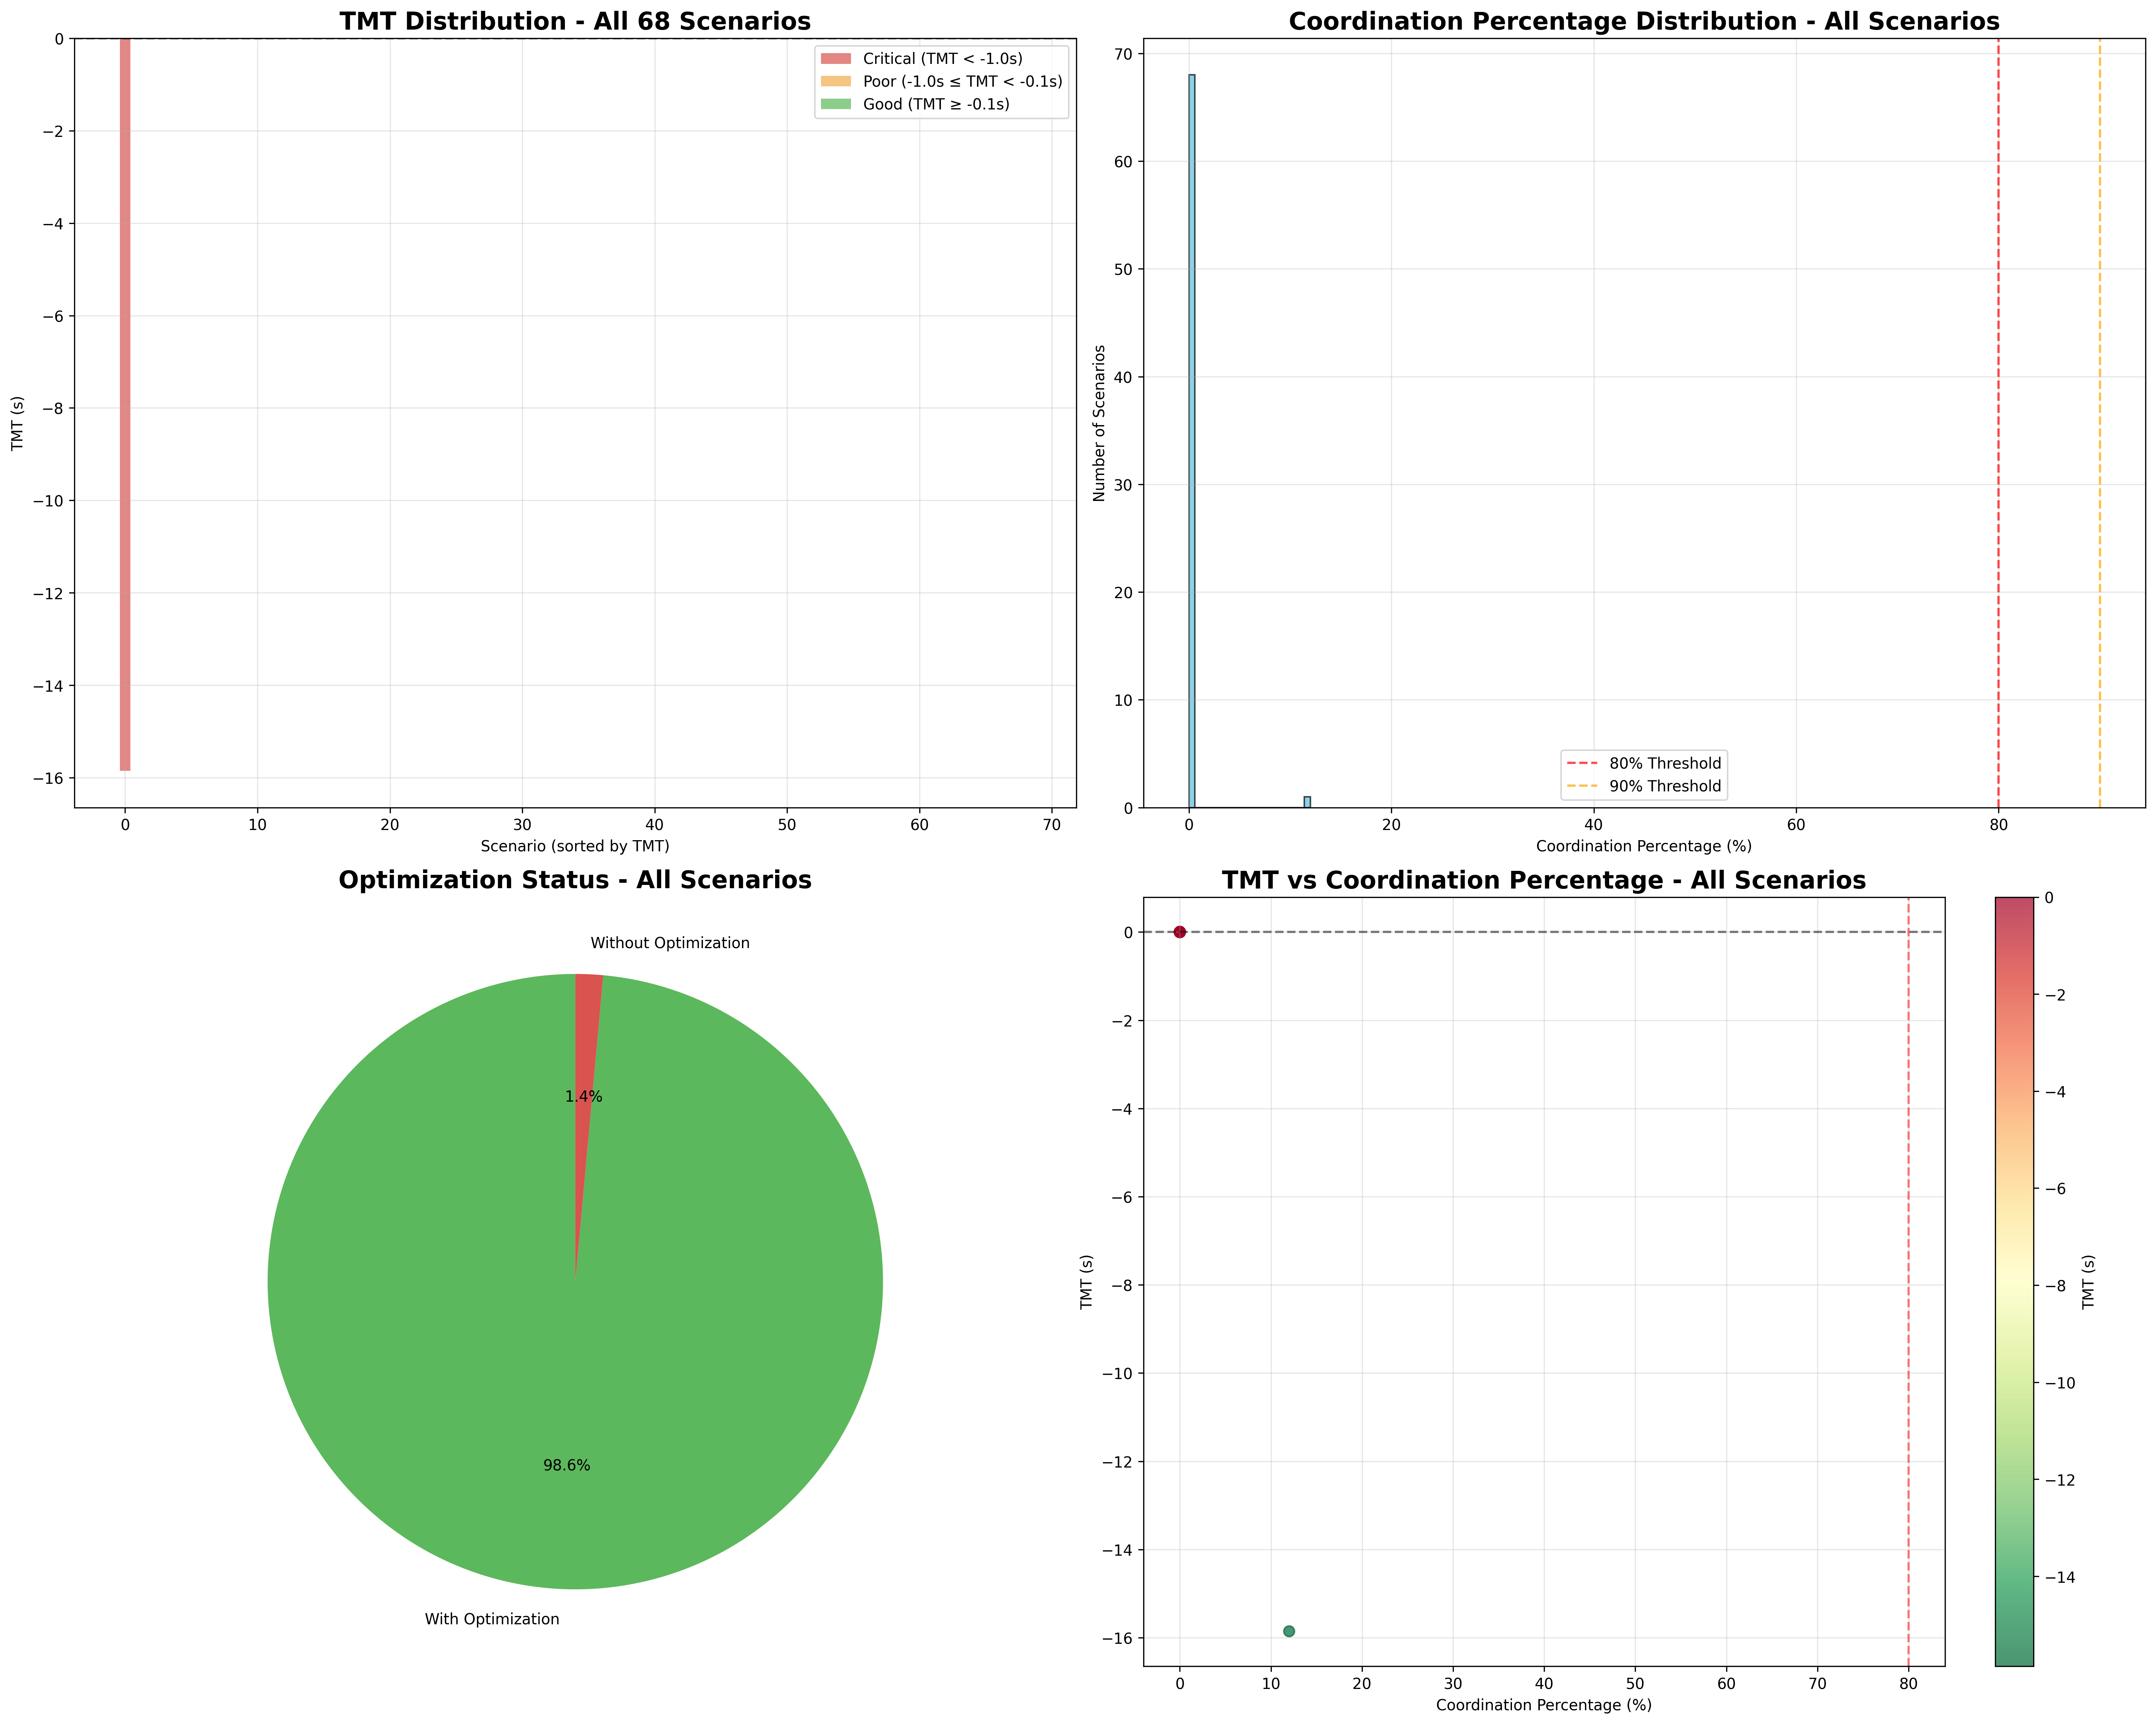

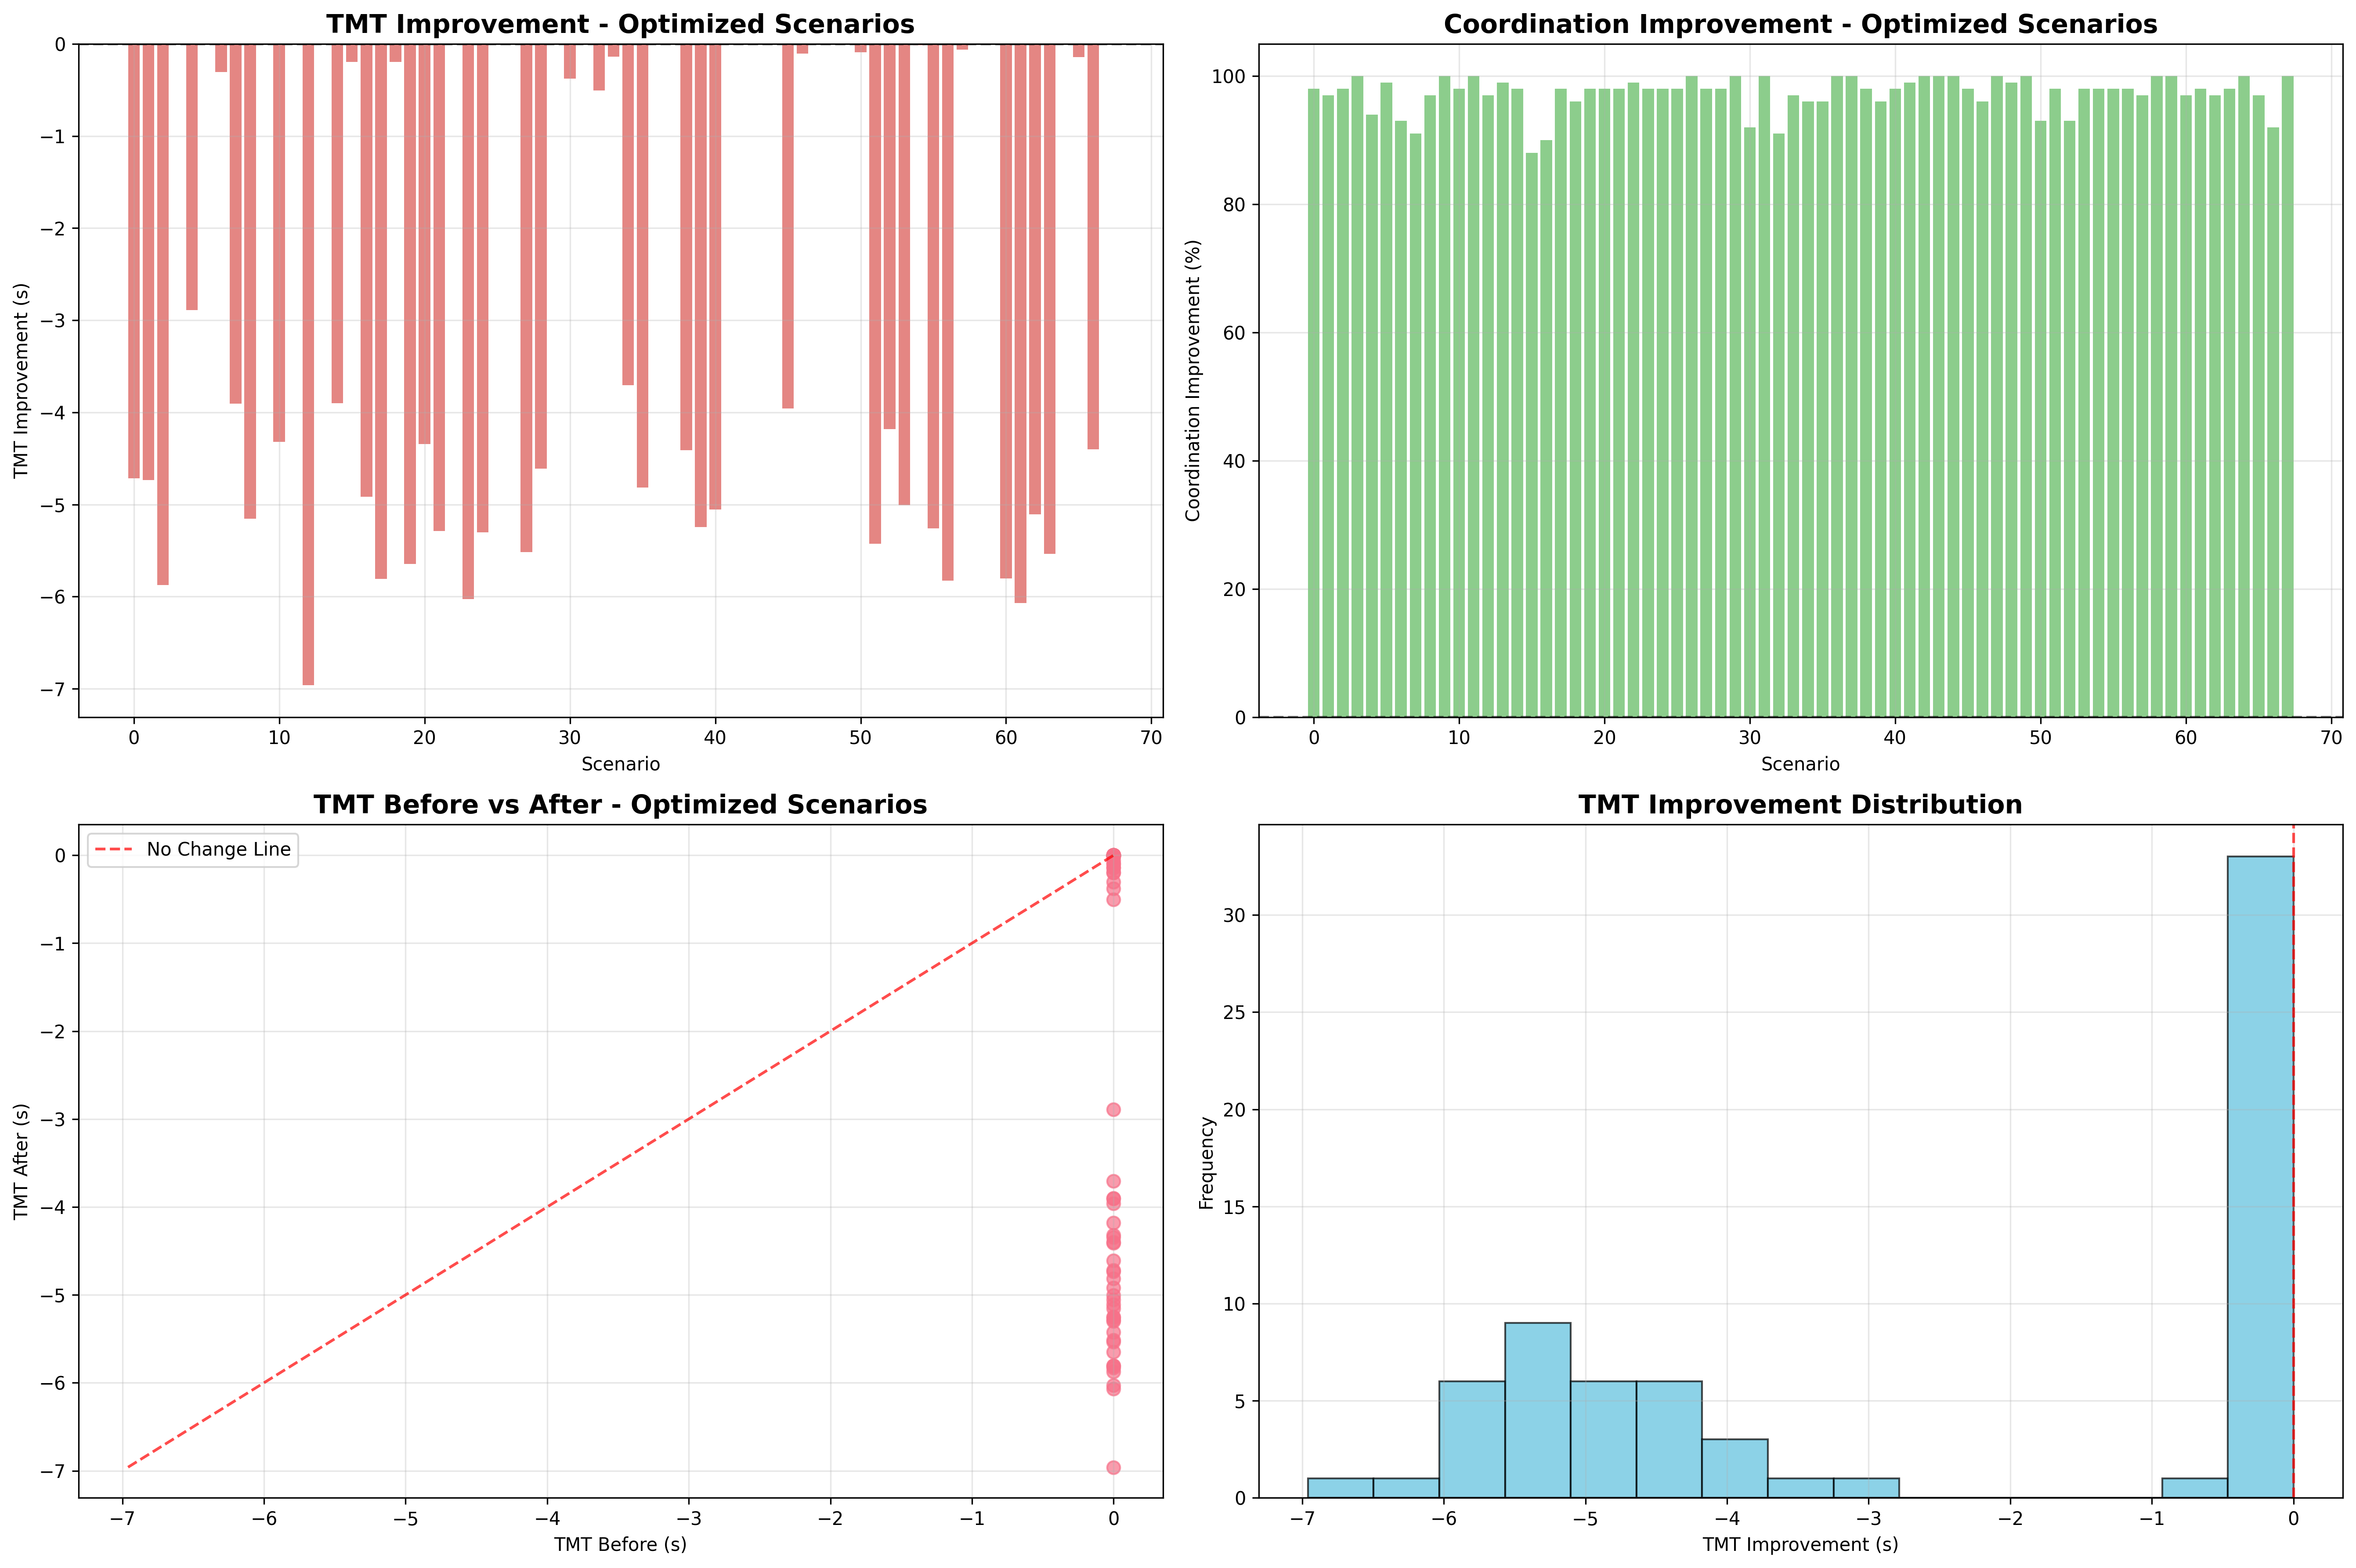


🎉 Comprehensive analysis for all 68 scenarios complete!
📁 Generated files:
  📄 Comprehensive report: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/reports/comprehensive_68_scenarios_report_20251007_170556.txt
  📊 Summary CSV: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/tables/all_68_scenarios_summary_20251007_170556.csv
  📈 Main visualization: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/comprehensive_68_scenarios_analysis_20251007_170556.png
  📈 Optimization effectiveness: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/figures/optimization_effectiveness_analysis_20251007_170556.png


In [61]:
# %% Comprehensive Visualization for ALL 68 Scenarios
def create_comprehensive_68_scenarios_visualization(all_scenario_results):
    """Create comprehensive visualizations for all 68 scenarios."""
    timestamp = config.timestamp
    
    # Separate scenarios with and without optimization
    scenarios_with_opt = {k: v for k, v in all_scenario_results.items() if v['has_optimization']}
    scenarios_without_opt = {k: v for k, v in all_scenario_results.items() if not v['has_optimization']}
    
    # Create main comprehensive figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. TMT Distribution for All Scenarios
    all_tmt = [v['before']['tmt_signed'] for v in all_scenario_results.values()]
    all_scenarios = list(all_scenario_results.keys())
    
    # Sort by TMT for better visualization
    sorted_indices = np.argsort(all_tmt)
    sorted_tmt = [all_tmt[i] for i in sorted_indices]
    sorted_scenarios = [all_scenarios[i] for i in sorted_indices]
    
    colors = ['#d9534f' if tmt < -1.0 else '#f0ad4e' if tmt < -0.1 else '#5cb85c' for tmt in sorted_tmt]
    bars = ax1.bar(range(len(sorted_tmt)), sorted_tmt, color=colors, alpha=0.7)
    ax1.set_title('TMT Distribution - All 68 Scenarios', fontsize=16, fontweight='bold')
    ax1.set_ylabel('TMT (s)')
    ax1.set_xlabel('Scenario (sorted by TMT)')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d9534f', alpha=0.7, label='Critical (TMT < -1.0s)'),
        Patch(facecolor='#f0ad4e', alpha=0.7, label='Poor (-1.0s ≤ TMT < -0.1s)'),
        Patch(facecolor='#5cb85c', alpha=0.7, label='Good (TMT ≥ -0.1s)')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # 2. Coordination Percentage Distribution
    all_coord = [v['before']['coordination_percentage'] for v in all_scenario_results.values()]
    ax2.hist(all_coord, bins=20, alpha=0.7, color='#5bc0de', edgecolor='black')
    ax2.set_title('Coordination Percentage Distribution - All Scenarios', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Coordination Percentage (%)')
    ax2.set_ylabel('Number of Scenarios')
    ax2.axvline(x=80, color='red', linestyle='--', alpha=0.7, label='80% Threshold')
    ax2.axvline(x=90, color='orange', linestyle='--', alpha=0.7, label='90% Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Scenarios with vs without Optimization
    opt_counts = [len(scenarios_with_opt), len(scenarios_without_opt)]
    opt_labels = ['With Optimization', 'Without Optimization']
    colors_pie = ['#5cb85c', '#d9534f']
    
    wedges, texts, autotexts = ax3.pie(opt_counts, labels=opt_labels, autopct='%1.1f%%', 
                                       colors=colors_pie, startangle=90)
    ax3.set_title('Optimization Status - All Scenarios', fontsize=16, fontweight='bold')
    
    # 4. TMT vs Coordination Scatter Plot
    ax4.scatter(all_coord, all_tmt, alpha=0.7, s=50, c=all_tmt, cmap='RdYlGn_r')
    ax4.set_title('TMT vs Coordination Percentage - All Scenarios', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Coordination Percentage (%)')
    ax4.set_ylabel('TMT (s)')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=80, color='red', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(ax4.collections[0], ax=ax4)
    cbar.set_label('TMT (s)')
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = config.FIGURES_DIR / f"comprehensive_68_scenarios_analysis_{timestamp}.png"
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Comprehensive visualization saved: {fig_path}")
    
    return fig, fig_path

def create_optimization_effectiveness_visualization(all_scenario_results):
    """Create visualization showing optimization effectiveness."""
    timestamp = config.timestamp
    
    # Filter scenarios with optimization
    scenarios_with_opt = {k: v for k, v in all_scenario_results.items() if v['has_optimization']}
    
    if not scenarios_with_opt:
        print("⚠️  No scenarios with optimization data available for effectiveness visualization")
        return None, None
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. TMT Improvement
    tmt_improvements = [v['improvements']['tmt_improvement'] for v in scenarios_with_opt.values()]
    scenario_names = list(scenarios_with_opt.keys())
    
    colors = ['#5cb85c' if imp > 0 else '#d9534f' for imp in tmt_improvements]
    bars = ax1.bar(range(len(tmt_improvements)), tmt_improvements, color=colors, alpha=0.7)
    ax1.set_title('TMT Improvement - Optimized Scenarios', fontsize=14, fontweight='bold')
    ax1.set_ylabel('TMT Improvement (s)')
    ax1.set_xlabel('Scenario')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # 2. Coordination Improvement
    coord_improvements = [v['improvements']['coord_improvement'] for v in scenarios_with_opt.values()]
    colors = ['#5cb85c' if imp > 0 else '#d9534f' for imp in coord_improvements]
    bars = ax2.bar(range(len(coord_improvements)), coord_improvements, color=colors, alpha=0.7)
    ax2.set_title('Coordination Improvement - Optimized Scenarios', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Coordination Improvement (%)')
    ax2.set_xlabel('Scenario')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Before vs After TMT
    tmt_before = [v['before']['tmt_signed'] for v in scenarios_with_opt.values()]
    tmt_after = [v['after']['tmt_signed'] for v in scenarios_with_opt.values()]
    
    ax3.scatter(tmt_before, tmt_after, alpha=0.7, s=50)
    min_val = min(min(tmt_before), min(tmt_after))
    max_val = max(max(tmt_before), max(tmt_after))
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='No Change Line')
    ax3.set_title('TMT Before vs After - Optimized Scenarios', fontsize=14, fontweight='bold')
    ax3.set_xlabel('TMT Before (s)')
    ax3.set_ylabel('TMT After (s)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Improvement Distribution
    ax4.hist(tmt_improvements, bins=15, alpha=0.7, color='#5bc0de', edgecolor='black')
    ax4.set_title('TMT Improvement Distribution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('TMT Improvement (s)')
    ax4.set_ylabel('Frequency')
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = config.FIGURES_DIR / f"optimization_effectiveness_analysis_{timestamp}.png"
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Optimization effectiveness visualization saved: {fig_path}")
    
    return fig, fig_path

# Generate comprehensive visualizations
print("🎨 Creating comprehensive visualizations for all 68 scenarios...")

fig1, path1 = create_comprehensive_68_scenarios_visualization(all_scenario_results)
fig2, path2 = create_optimization_effectiveness_visualization(all_scenario_results)

# Display figures inline
try:
    display(Image(filename=str(path1)))
    if path2:
        display(Image(filename=str(path2)))
except Exception as e:
    print(f"⚠️  Could not display images inline: {e}")

print("\n🎉 Comprehensive analysis for all 68 scenarios complete!")
print("📁 Generated files:")
print(f"  📄 Comprehensive report: {report_path}")
print(f"  📊 Summary CSV: {config.TABLES_DIR / f'all_68_scenarios_summary_{timestamp}.csv'}")
print(f"  📈 Main visualization: {path1}")
if path2:
    print(f"  📈 Optimization effectiveness: {path2}")
